# Compare vaccination strategies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import datetime
from experiments import get_experiments_results
from env_var import EPIDEMIC, MAPPINGS, EXPERIMENTS

mpl.rcParams['figure.dpi']= 175
plt.style.use('ggplot')

In [2]:
# Simulation parameters
num_age_groups = EXPERIMENTS['num_age_groups']
num_ervas = EXPERIMENTS['num_ervas']
T = EXPERIMENTS['simulate_T']
init_vacc = EXPERIMENTS['init_vacc']
u = EXPERIMENTS['vaccines_per_day']
r_experiments = EXPERIMENTS['r_effs']
t0 = EXPERIMENTS['t0']

# Plot parameters
plot_interval = 15
ervas_labels = EPIDEMIC['ervas_order']
age_labels = MAPPINGS['age_groups'][num_age_groups]['names']

strategies = [
    ('equal', EPIDEMIC['ws_vacc'], 'Pop only'),
    ('no_vacc', EPIDEMIC['ws_vacc'], 'No vaccination'),
    ('thl', EPIDEMIC['ws_vacc'], 'Pop, Inf and Hosp'),
    ('thl', [1/2, 1/2, 0], 'Pop and Hosp'),
    ('thl', [1/2, 0, 1/2], 'Pop and Inf'),
    ('thl', [0, 1/2, 1/2], 'Hosp and Inf'),
    ('thl', [0, 1, 0], 'Hosp only'),
    ('thl', [0, 0, 1], 'Inf only'),
]

In [3]:
all_results = get_experiments_results(num_age_groups=num_age_groups,
                                      num_ervas=num_ervas,
                                      init_vacc=True,
                                      strategies=strategies,
                                      u=u,
                                      T=T,
                                      r_experiments=r_experiments,
                                      t0=t0)

rho: 42.30276820025355
Finished R: 1.0. Beta: 0.023639114945532246 1/4. Policy: Pop only. 1/8
Finished R: 1.0. Beta: 0.023639114945532246 1/4. Policy: No vaccination. 2/8
Finished R: 1.0. Beta: 0.023639114945532246 1/4. Policy: Pop, Inf and Hosp. 3/8
Finished R: 1.0. Beta: 0.023639114945532246 1/4. Policy: Pop and Hosp. 4/8
Finished R: 1.0. Beta: 0.023639114945532246 1/4. Policy: Pop and Inf. 5/8
Finished R: 1.0. Beta: 0.023639114945532246 1/4. Policy: Hosp and Inf. 6/8
Finished R: 1.0. Beta: 0.023639114945532246 1/4. Policy: Hosp only. 7/8
Finished R: 1.0. Beta: 0.023639114945532246 1/4. Policy: Inf only. 8/8
Finished R: 1.25. Beta: 0.02954889368191531 2/4. Policy: Pop only. 1/8
Finished R: 1.25. Beta: 0.02954889368191531 2/4. Policy: No vaccination. 2/8
Finished R: 1.25. Beta: 0.02954889368191531 2/4. Policy: Pop, Inf and Hosp. 3/8
Finished R: 1.25. Beta: 0.02954889368191531 2/4. Policy: Pop and Hosp. 4/8
Finished R: 1.25. Beta: 0.02954889368191531 2/4. Policy: Pop and Inf. 5/8
Finis

In [4]:
def plot_results(ax, r, metric, all_results, t0, T, skip_no_vacc=True):
    begin = datetime.datetime.strptime(t0, '%Y-%m-%d')
    x = [begin + datetime.timedelta(days=day) for day in range(T)]

    results_for_r = all_results[r]
    totals = []
    for label, results_all_metrics in results_for_r:
        if label == 'No vaccination' and skip_no_vacc:
            continue
        metric_results = results_all_metrics[metric]
        metric_all_time = metric_results.sum(axis=0)
        metric_all_time = metric_all_time.sum(axis=0)
        
        assert metric_all_time.shape[0] == T
        
        ax.plot(x, metric_all_time, label=label)
        if metric == 'deaths':
            total_policy = metric_all_time[-1]
        else:
            total_policy = metric_all_time.sum(axis=0)
        total = (label, total_policy)
        totals.append(total)
        
    sorted_totals = sorted(totals, key=lambda x: x[-1])
    for total in sorted_totals:
        print('%s: %s' % (total[0], total[1]))
        
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of %s.' % (metric, ))
    ax.set_title('Number of %s per policy. R=%s' % (metric, r))
    ax.legend()
        
    return ax

# Deaths

Pop and Inf: 87.33951968437157
Pop, Inf and Hosp: 87.34417062605046
Pop and Hosp: 87.36665823994186
Inf only: 87.41052808701177
Hosp and Inf: 87.41502537688669
Hosp only: 87.43785354654305
Pop only: 87.53468175567711


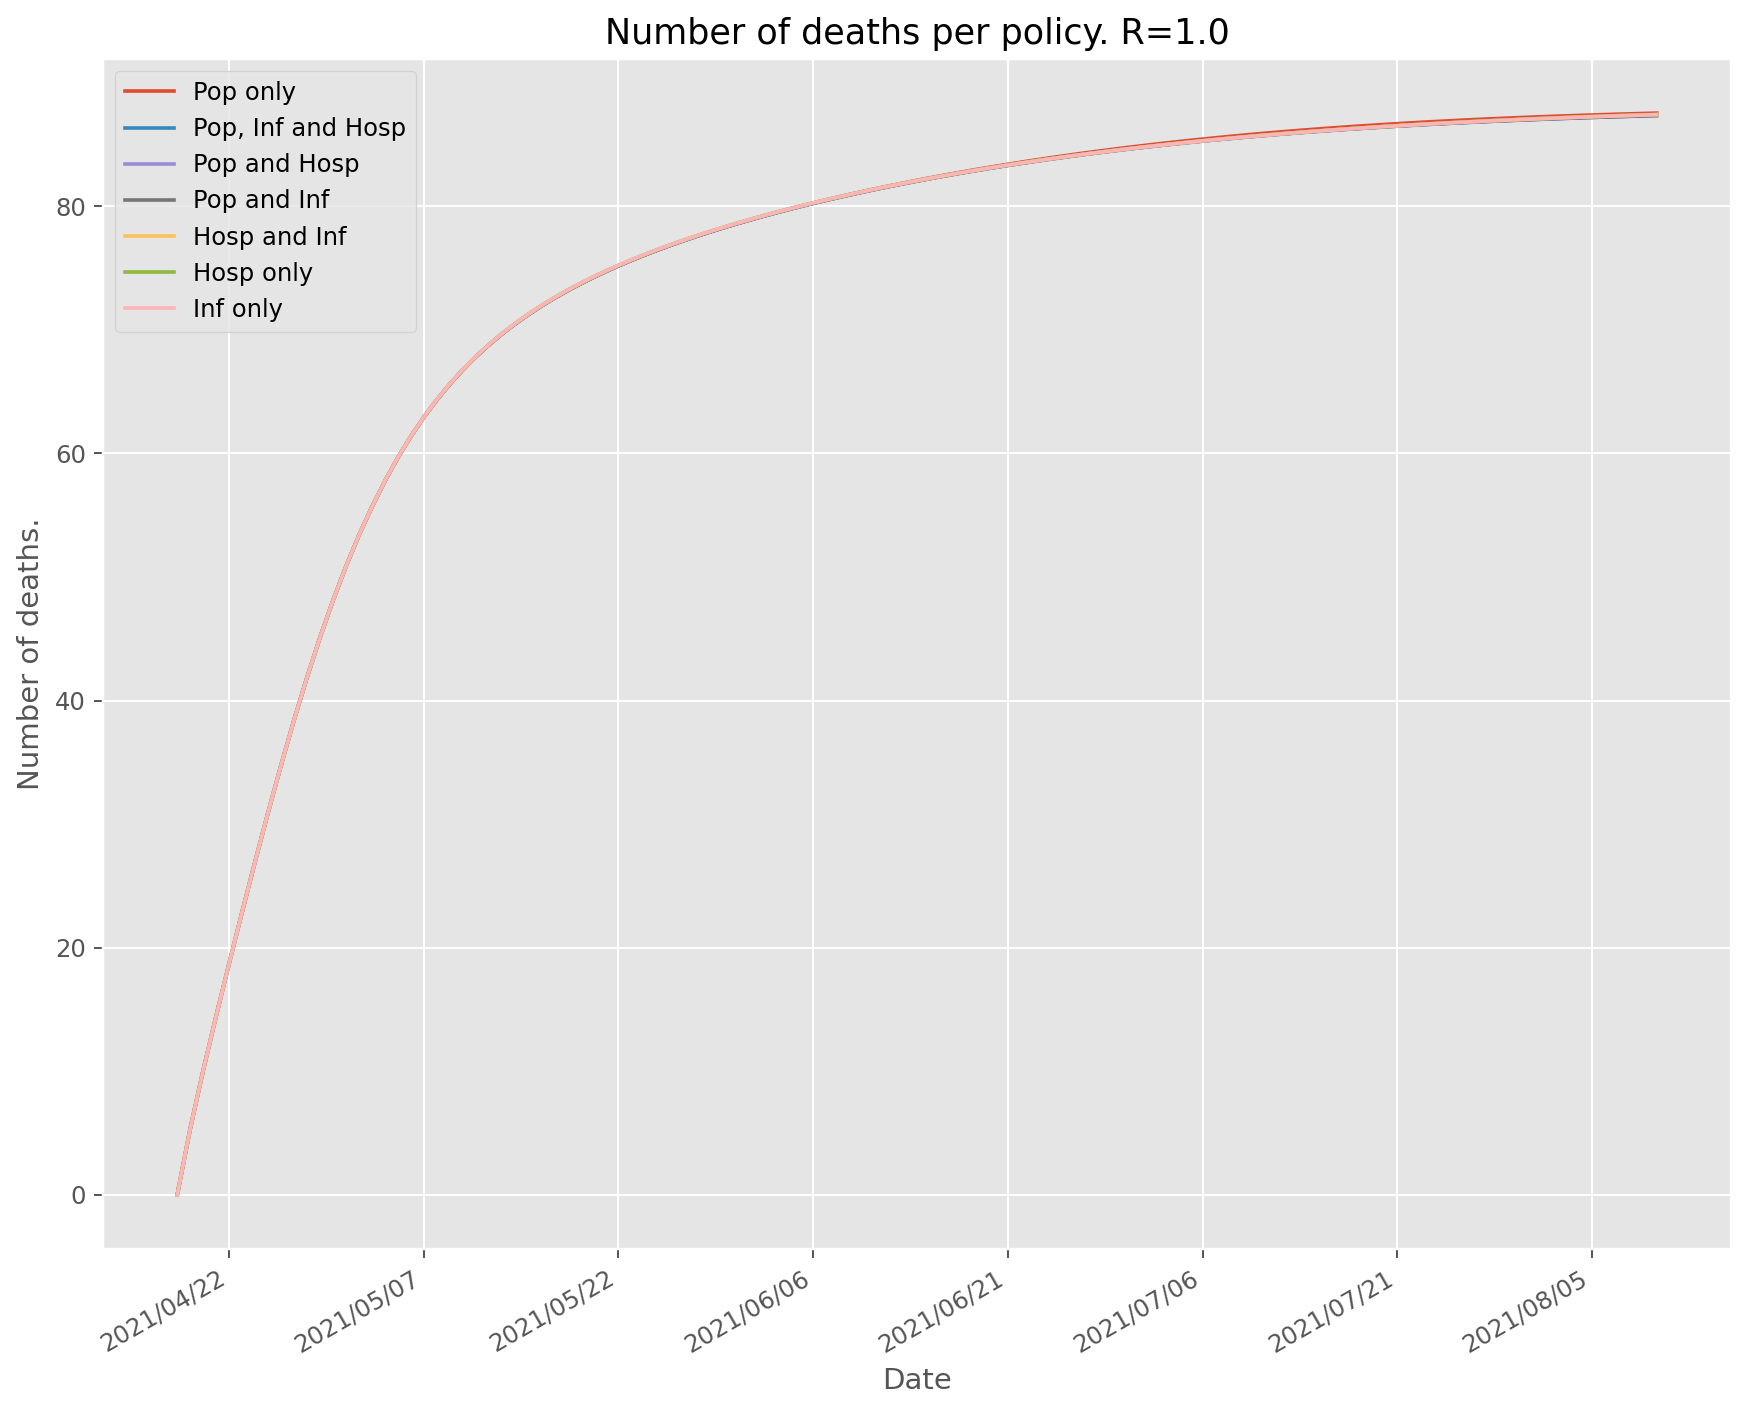

In [5]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[0], metric='deaths', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

Pop and Inf: 139.97654872456786
Pop and Hosp: 140.16065833215794
Pop only: 140.34357785291957
Pop, Inf and Hosp: 140.36986730009113
Inf only: 141.3556653280003
Hosp and Inf: 141.44027795630245
Hosp only: 141.58815642550425


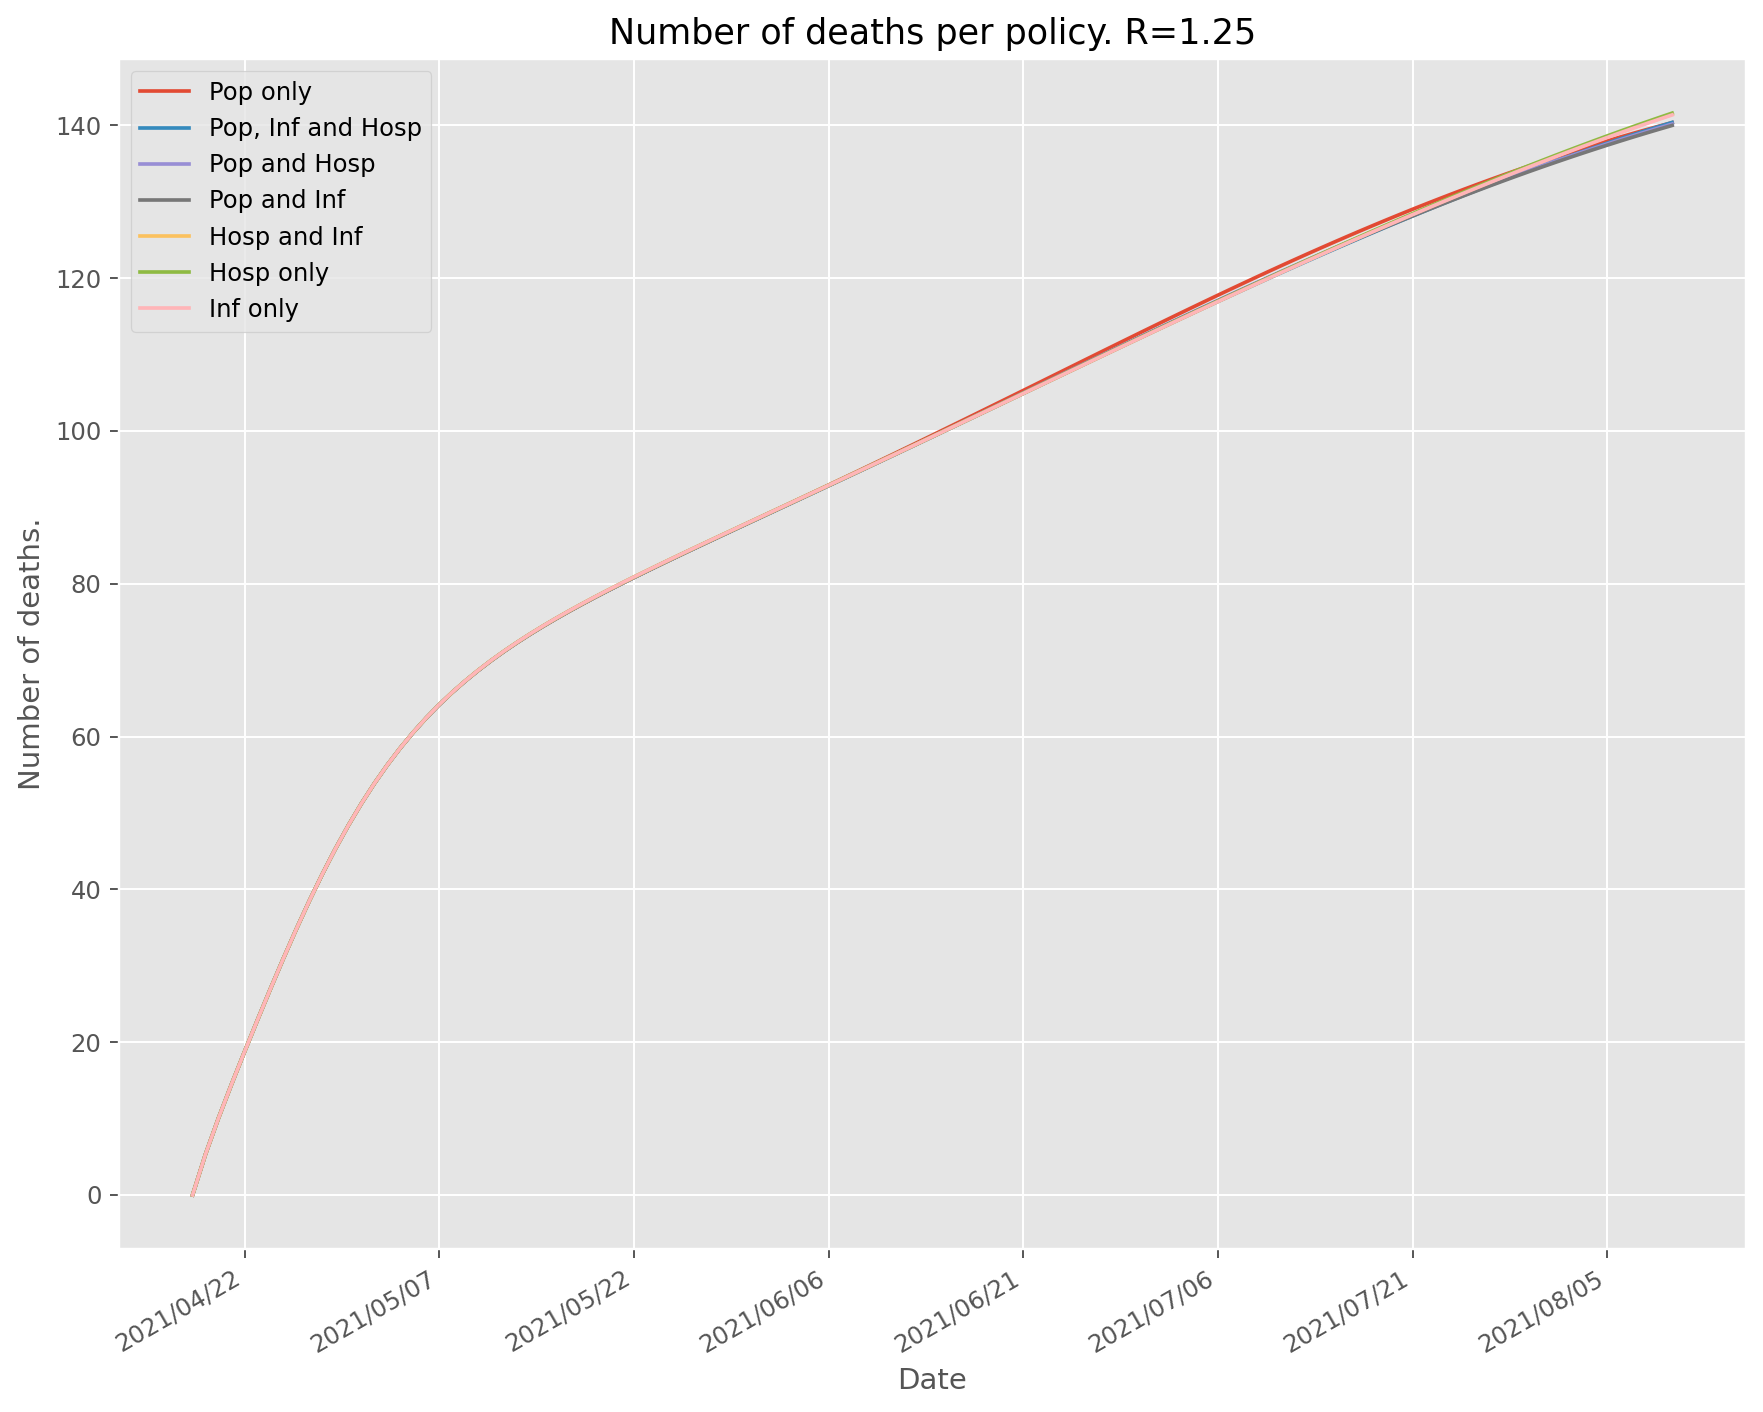

In [6]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[1], metric='deaths', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

Pop only: 340.71953490533303
Pop and Inf: 346.9264028853212
Pop and Hosp: 347.8286034677816
Pop, Inf and Hosp: 351.069906621578
Inf only: 359.6361709844613
Hosp and Inf: 359.9476737327998
Hosp only: 360.52036482422693


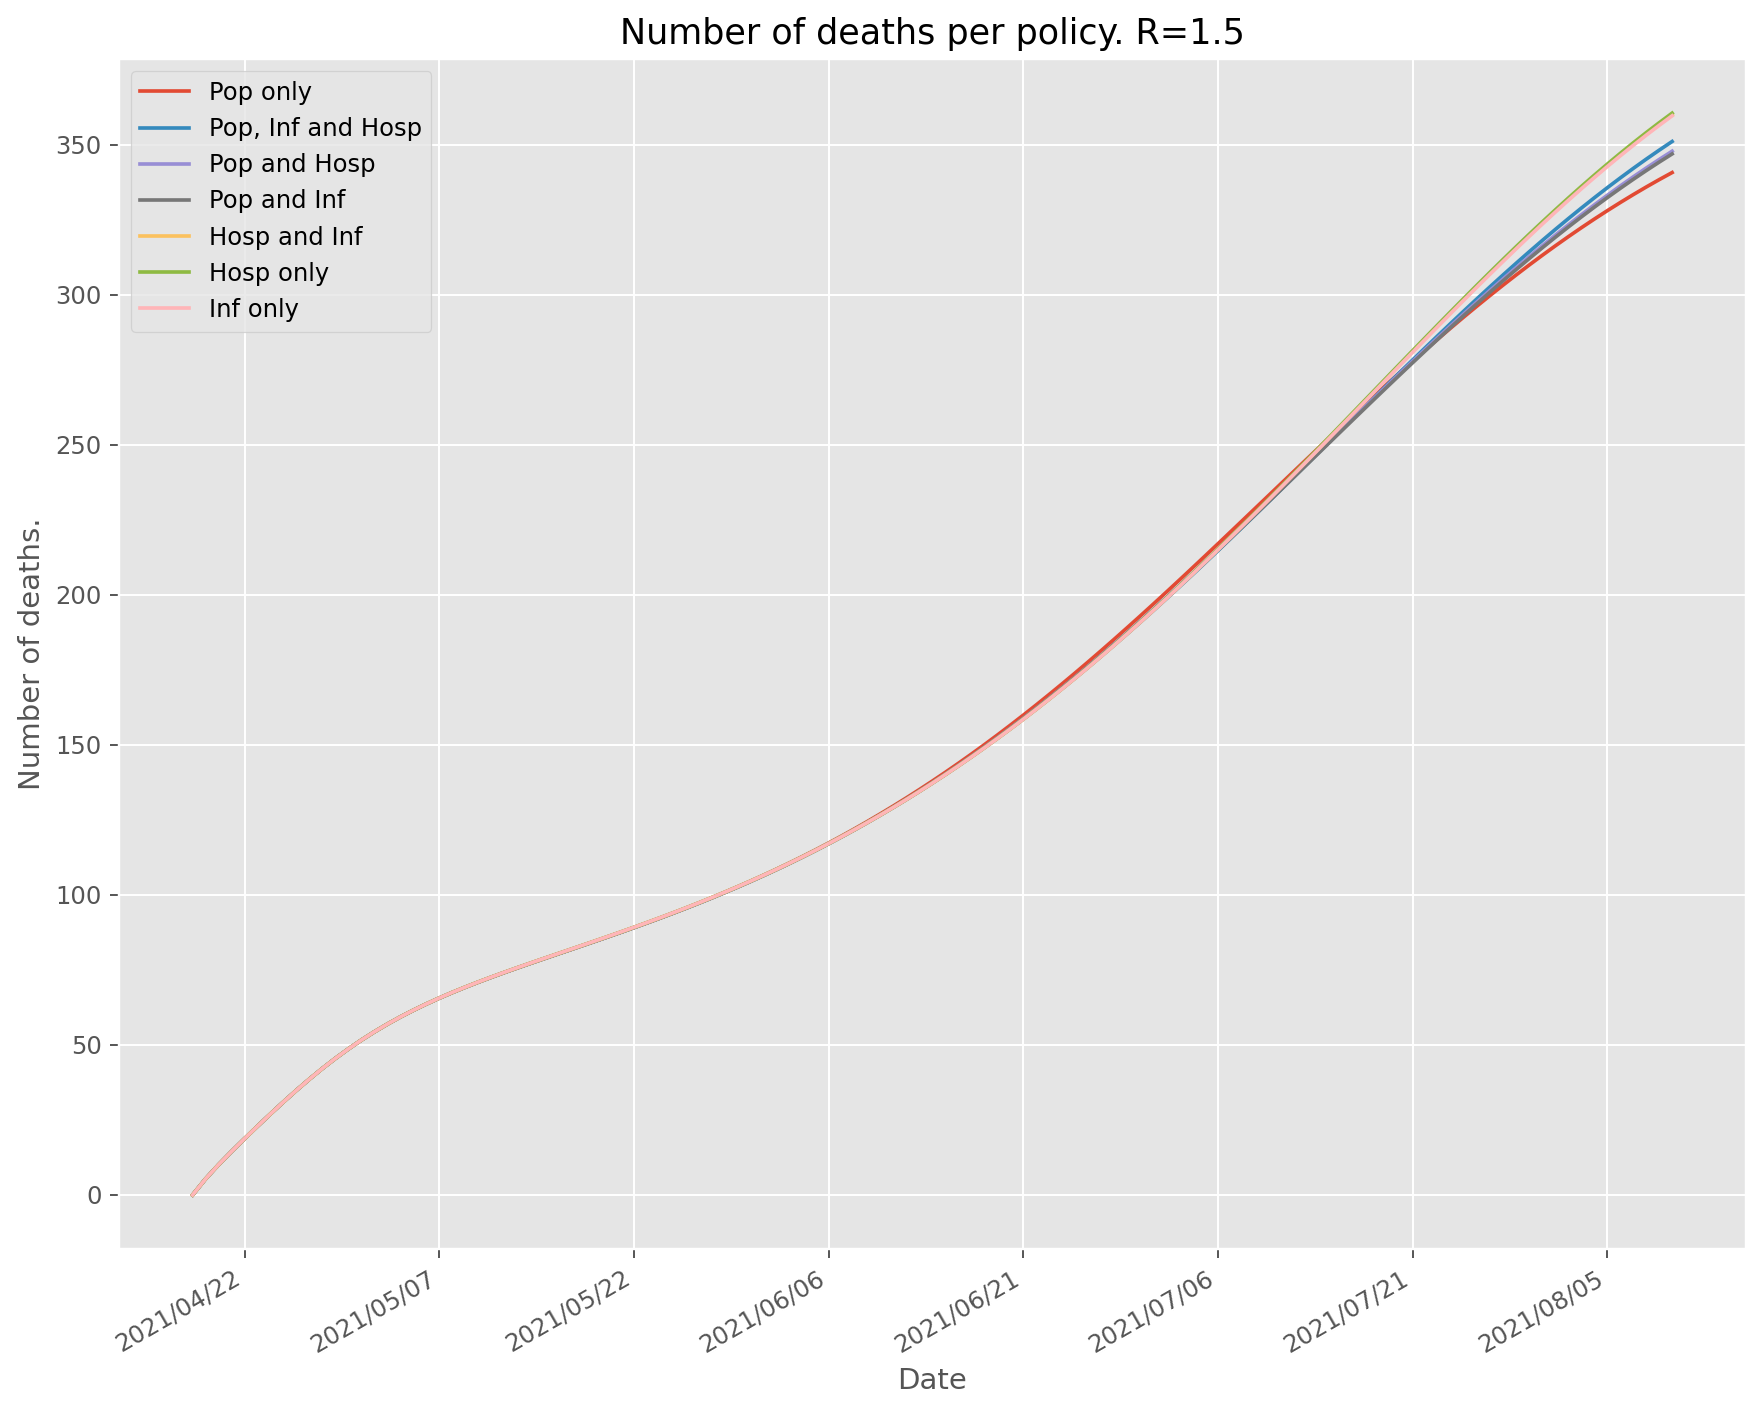

In [7]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[2], metric='deaths', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

Pop only: 1177.1120888525734
Pop and Inf: 1209.2108298468727
Pop and Hosp: 1211.5524490607518
Pop, Inf and Hosp: 1223.2095274851836
Hosp and Inf: 1256.2995255080468
Inf only: 1256.3907917751078
Hosp only: 1256.8735235675813


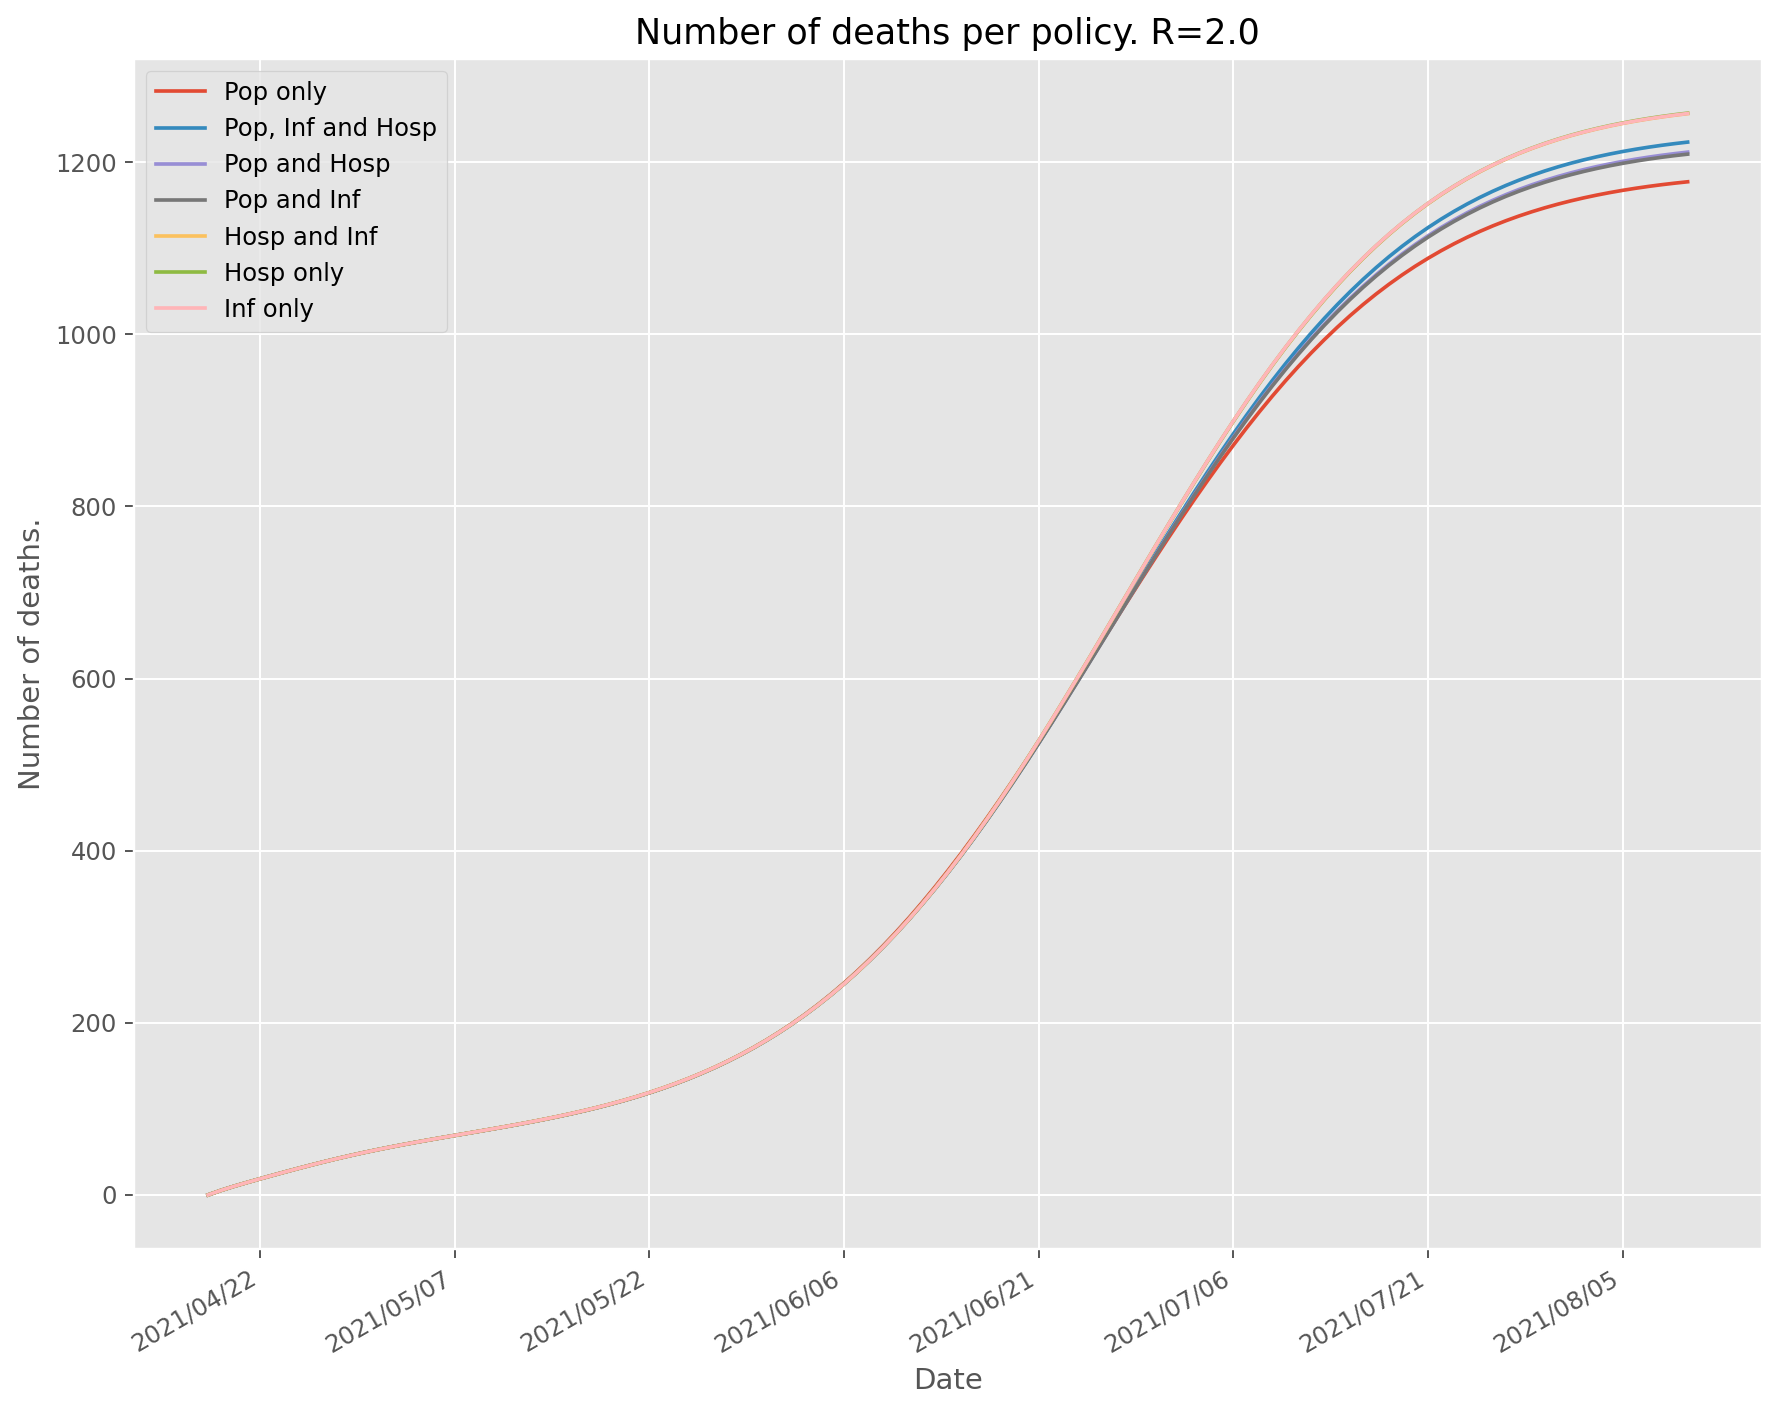

In [8]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[3], metric='deaths', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

# Death incidence

Pop and Inf: 87.33951968437158
Pop, Inf and Hosp: 87.34417062605046
Pop and Hosp: 87.36665823994186
Inf only: 87.41052808701176
Hosp and Inf: 87.4150253768867
Hosp only: 87.43785354654304
Pop only: 87.53468175567711


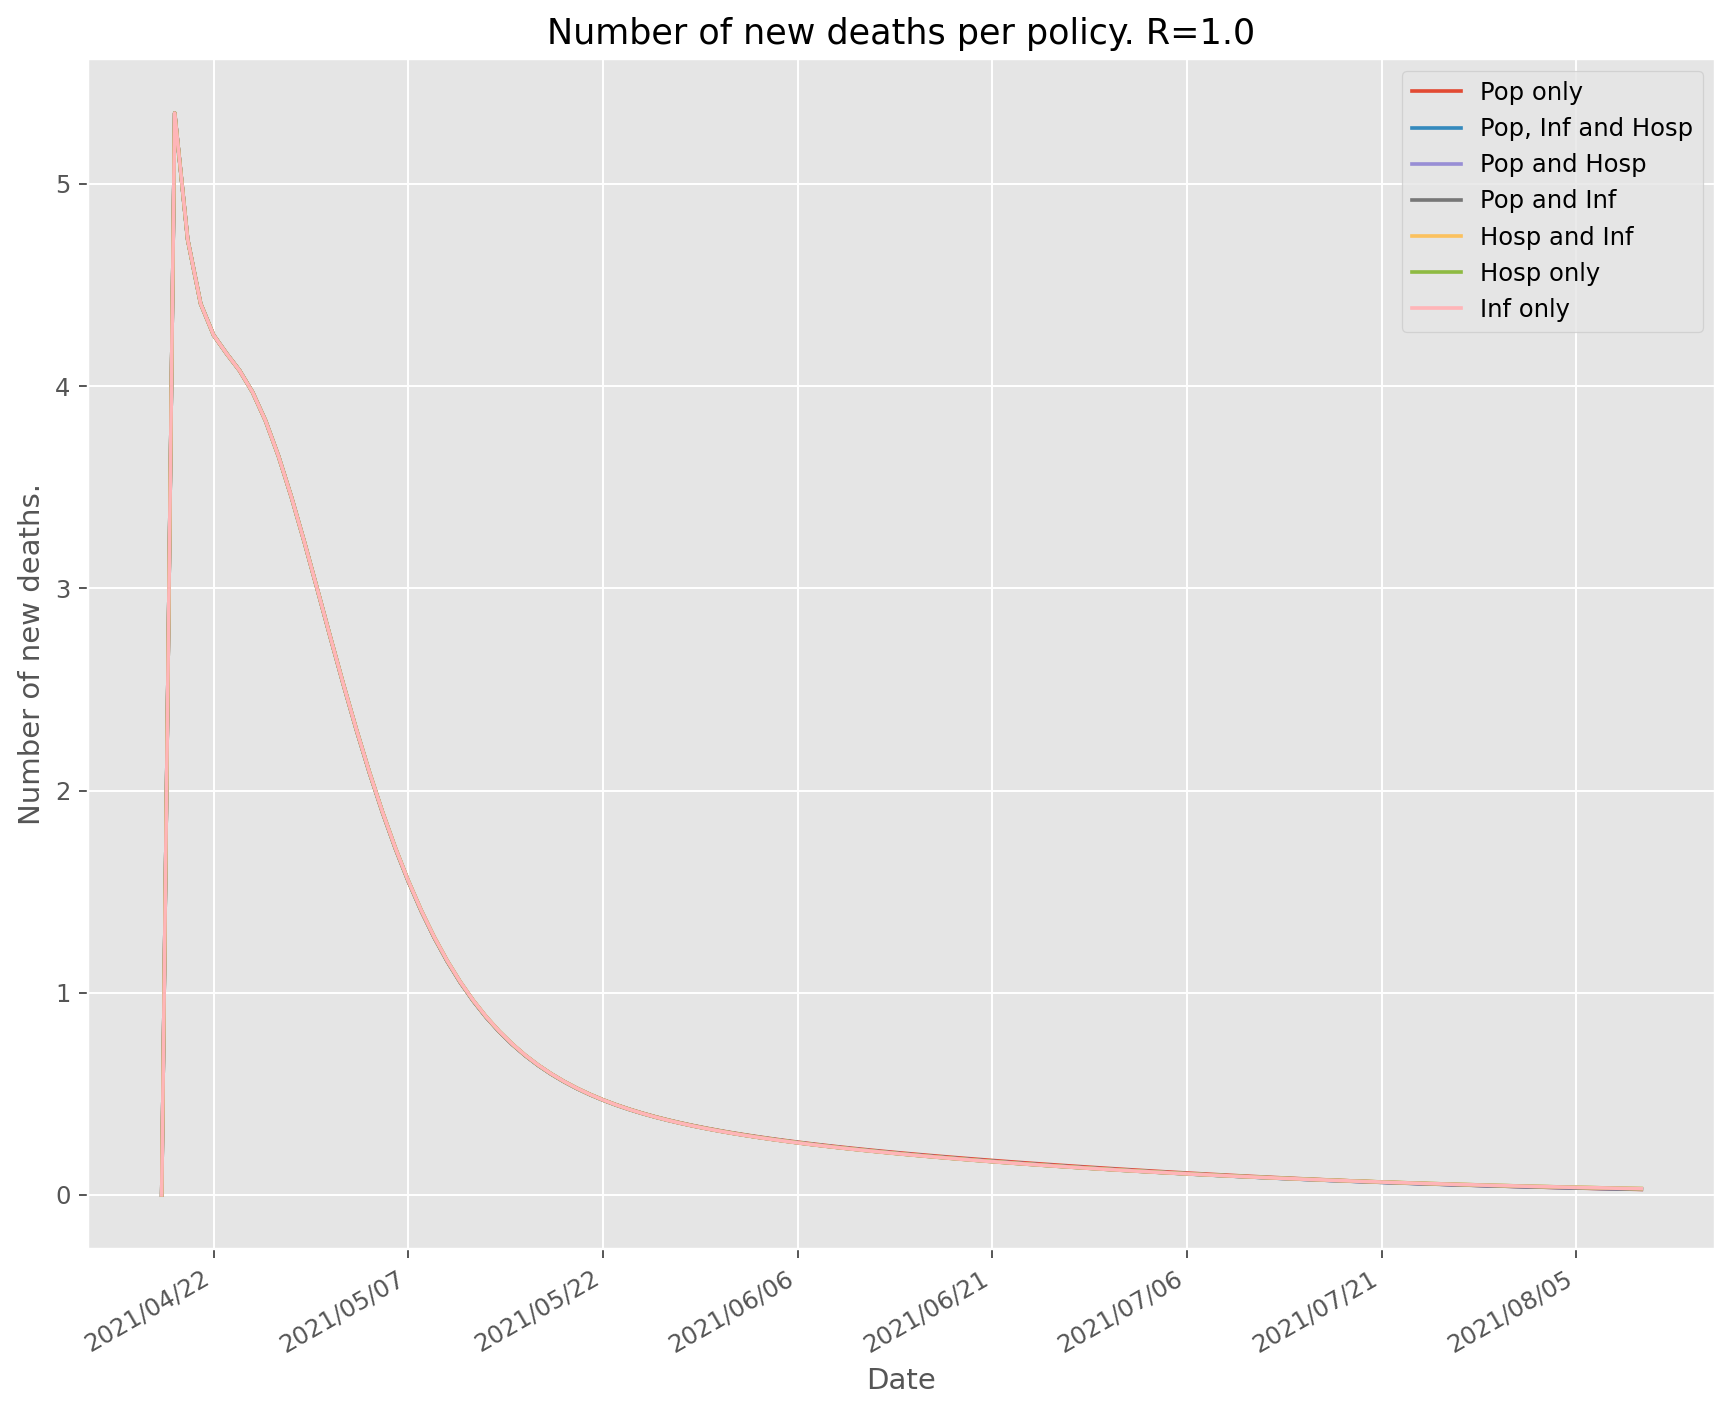

In [9]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[0], metric='new deaths', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

Pop and Inf: 139.97654872456786
Pop and Hosp: 140.16065833215794
Pop only: 140.3435778529196
Pop, Inf and Hosp: 140.36986730009113
Inf only: 141.35566532800033
Hosp and Inf: 141.44027795630245
Hosp only: 141.58815642550428


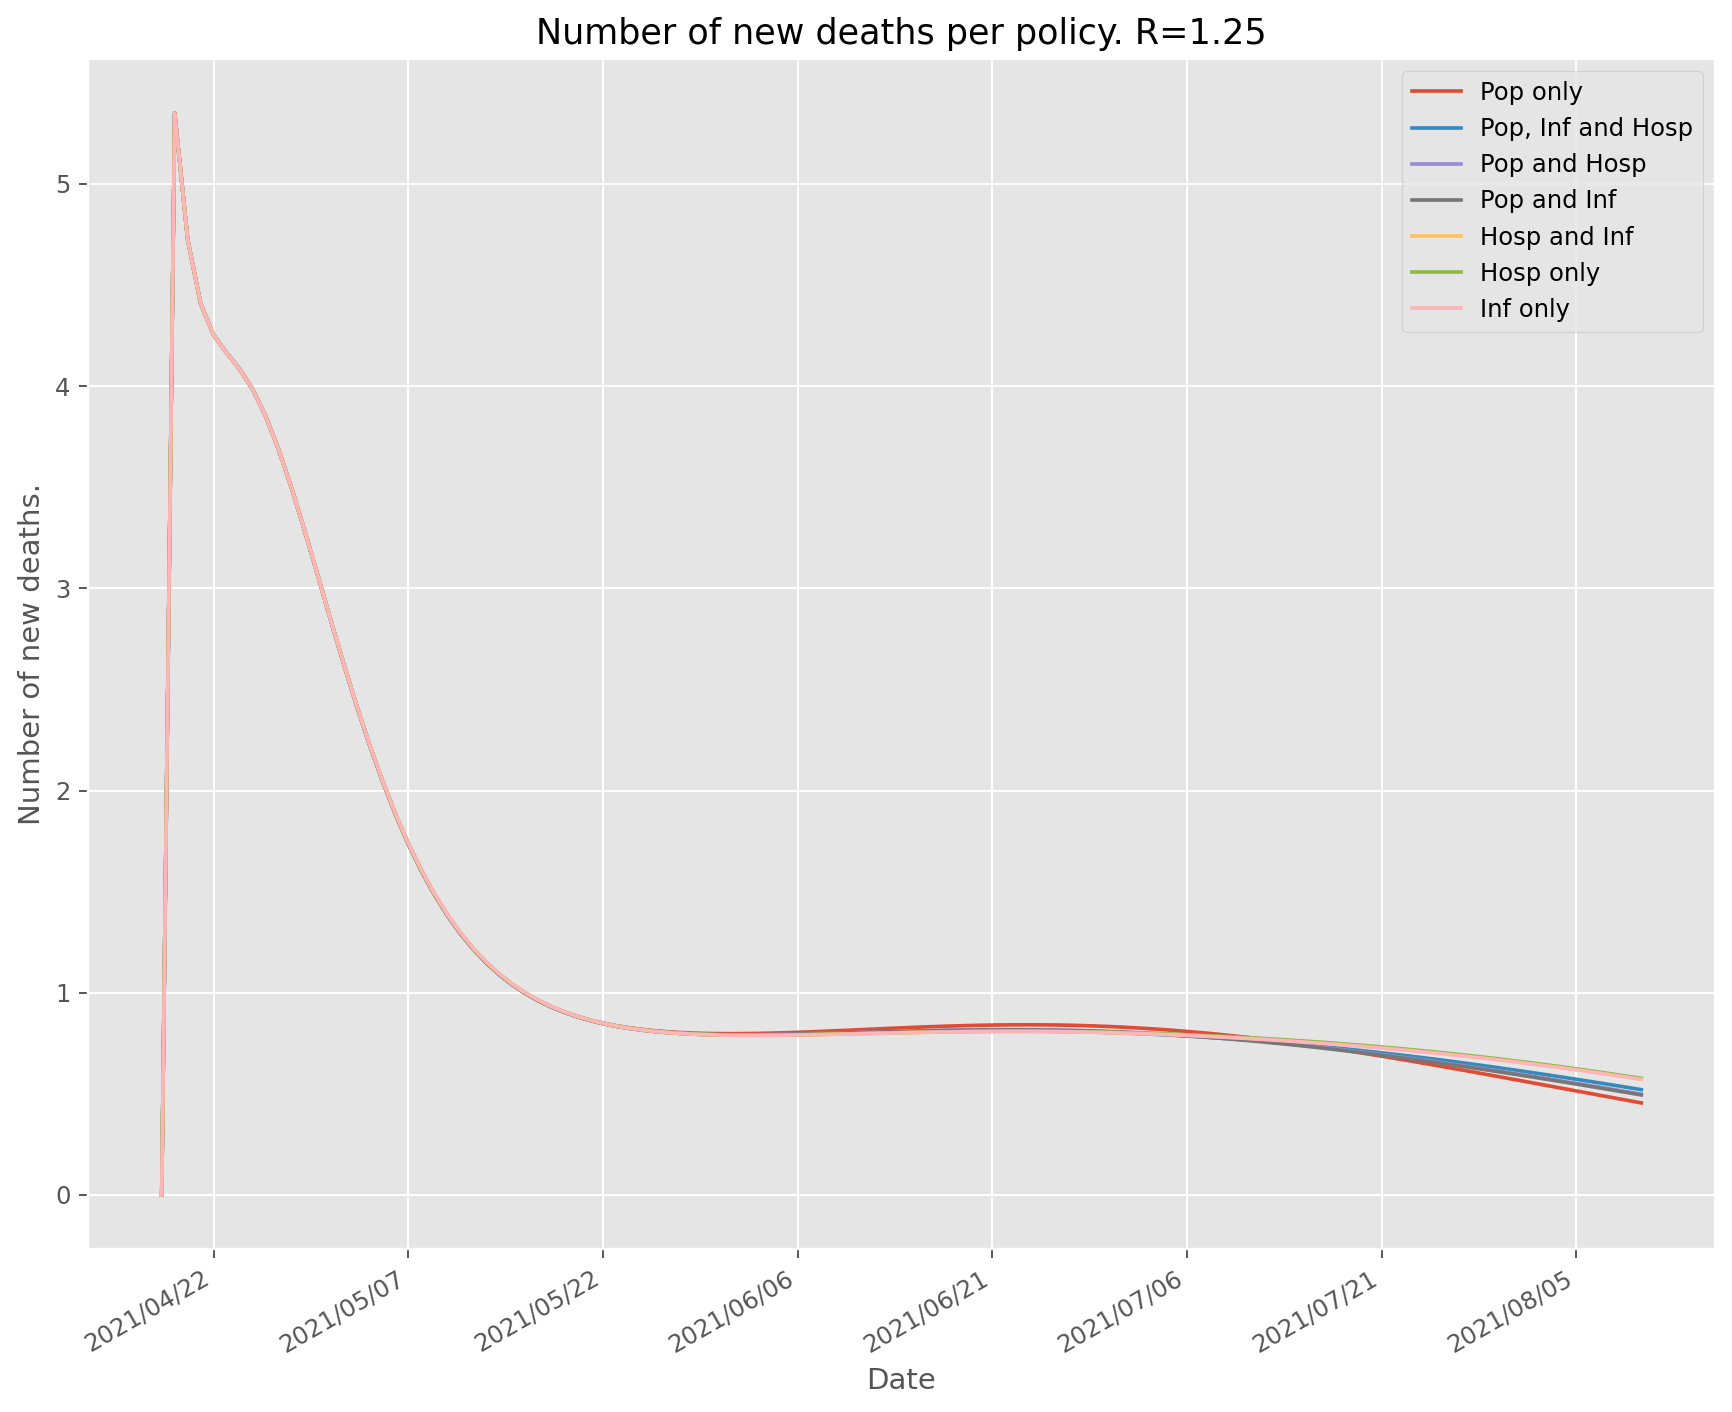

In [10]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[1], metric='new deaths', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

Pop only: 340.719534905333
Pop and Inf: 346.9264028853211
Pop and Hosp: 347.82860346778165
Pop, Inf and Hosp: 351.06990662157796
Inf only: 359.6361709844613
Hosp and Inf: 359.94767373279984
Hosp only: 360.52036482422693


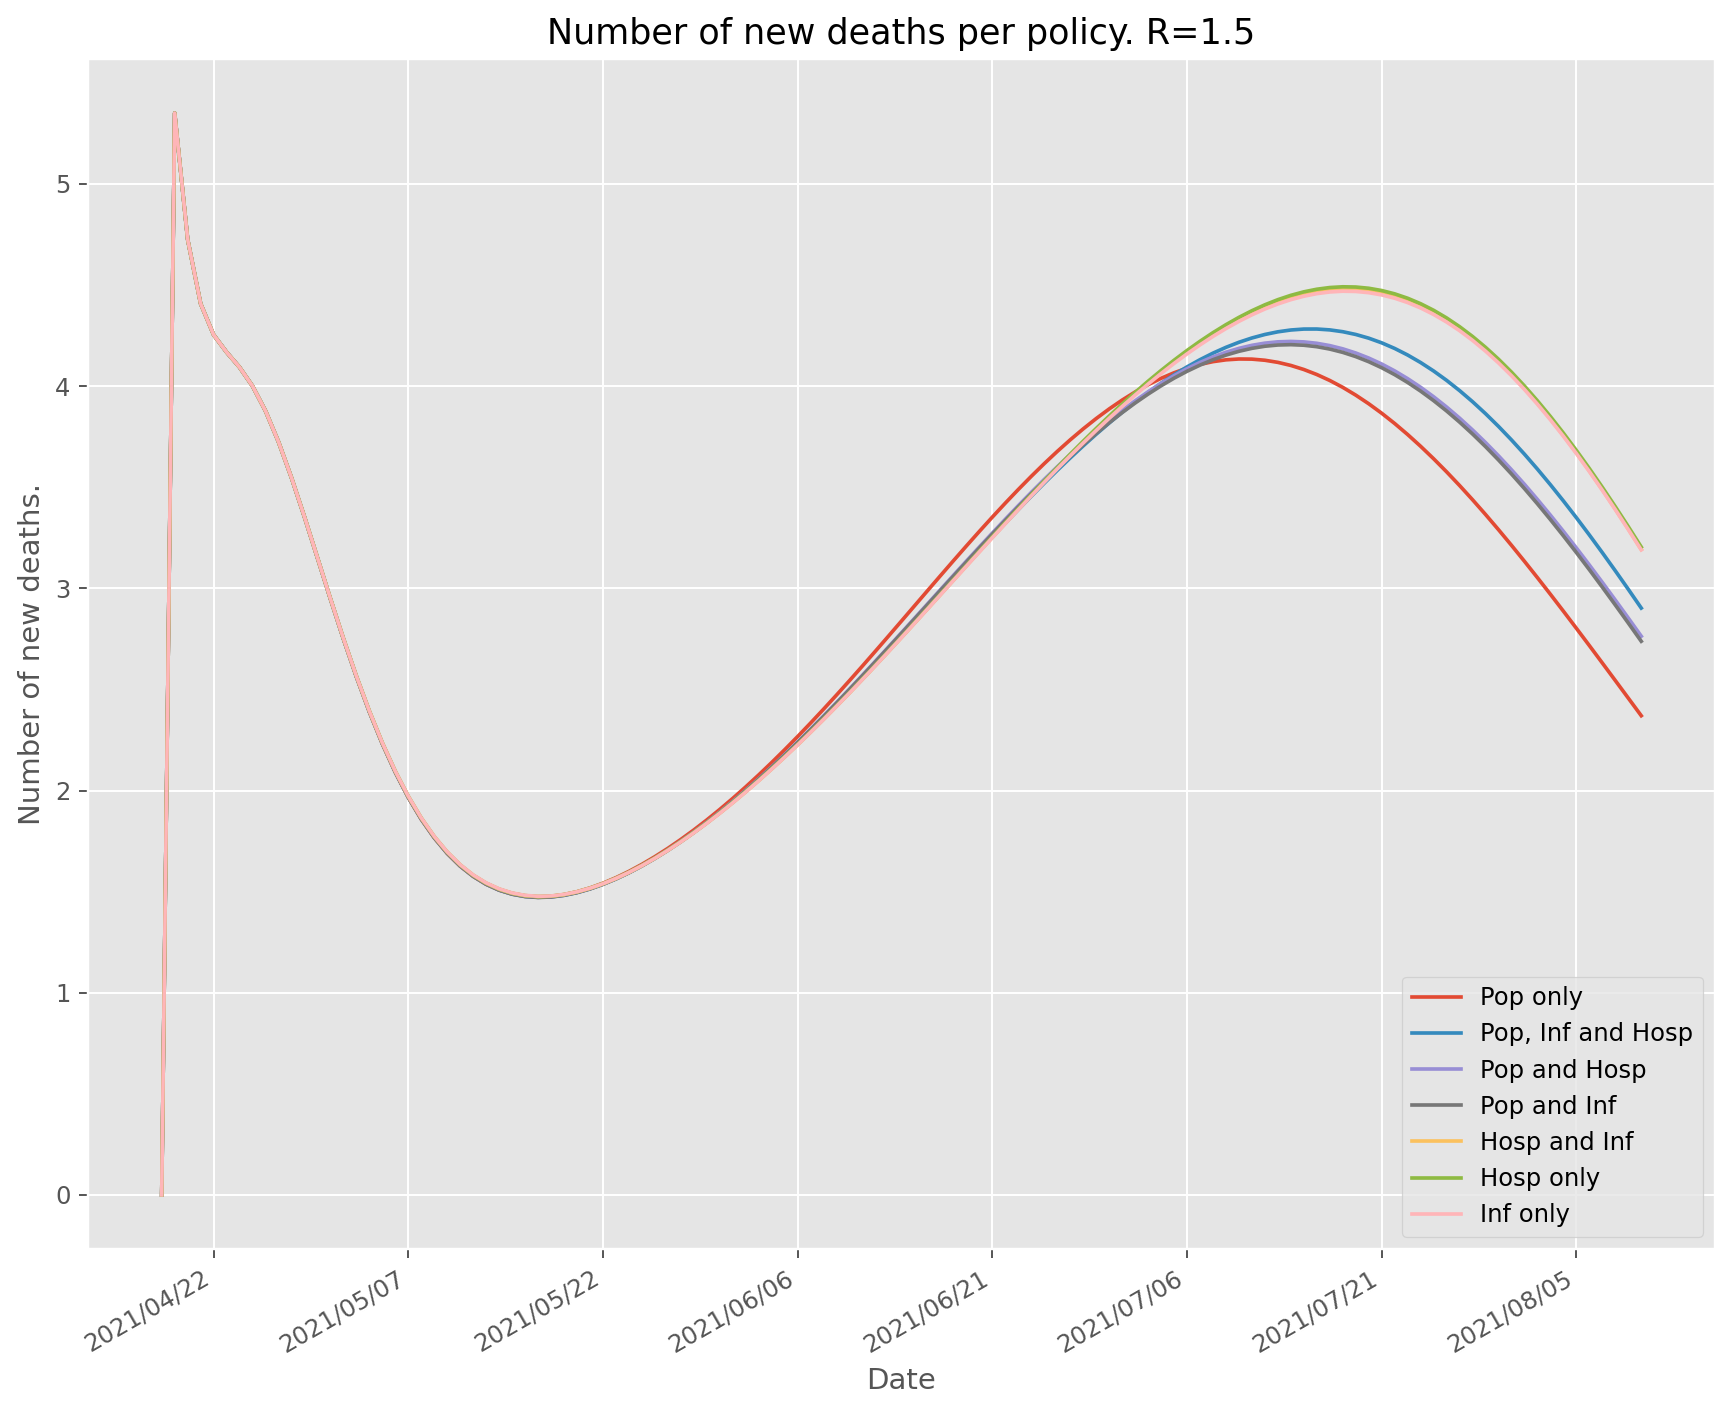

In [11]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[2], metric='new deaths', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

Pop only: 1177.1120888525732
Pop and Inf: 1209.2108298468727
Pop and Hosp: 1211.5524490607518
Pop, Inf and Hosp: 1223.2095274851836
Hosp and Inf: 1256.2995255080468
Inf only: 1256.3907917751078
Hosp only: 1256.8735235675813


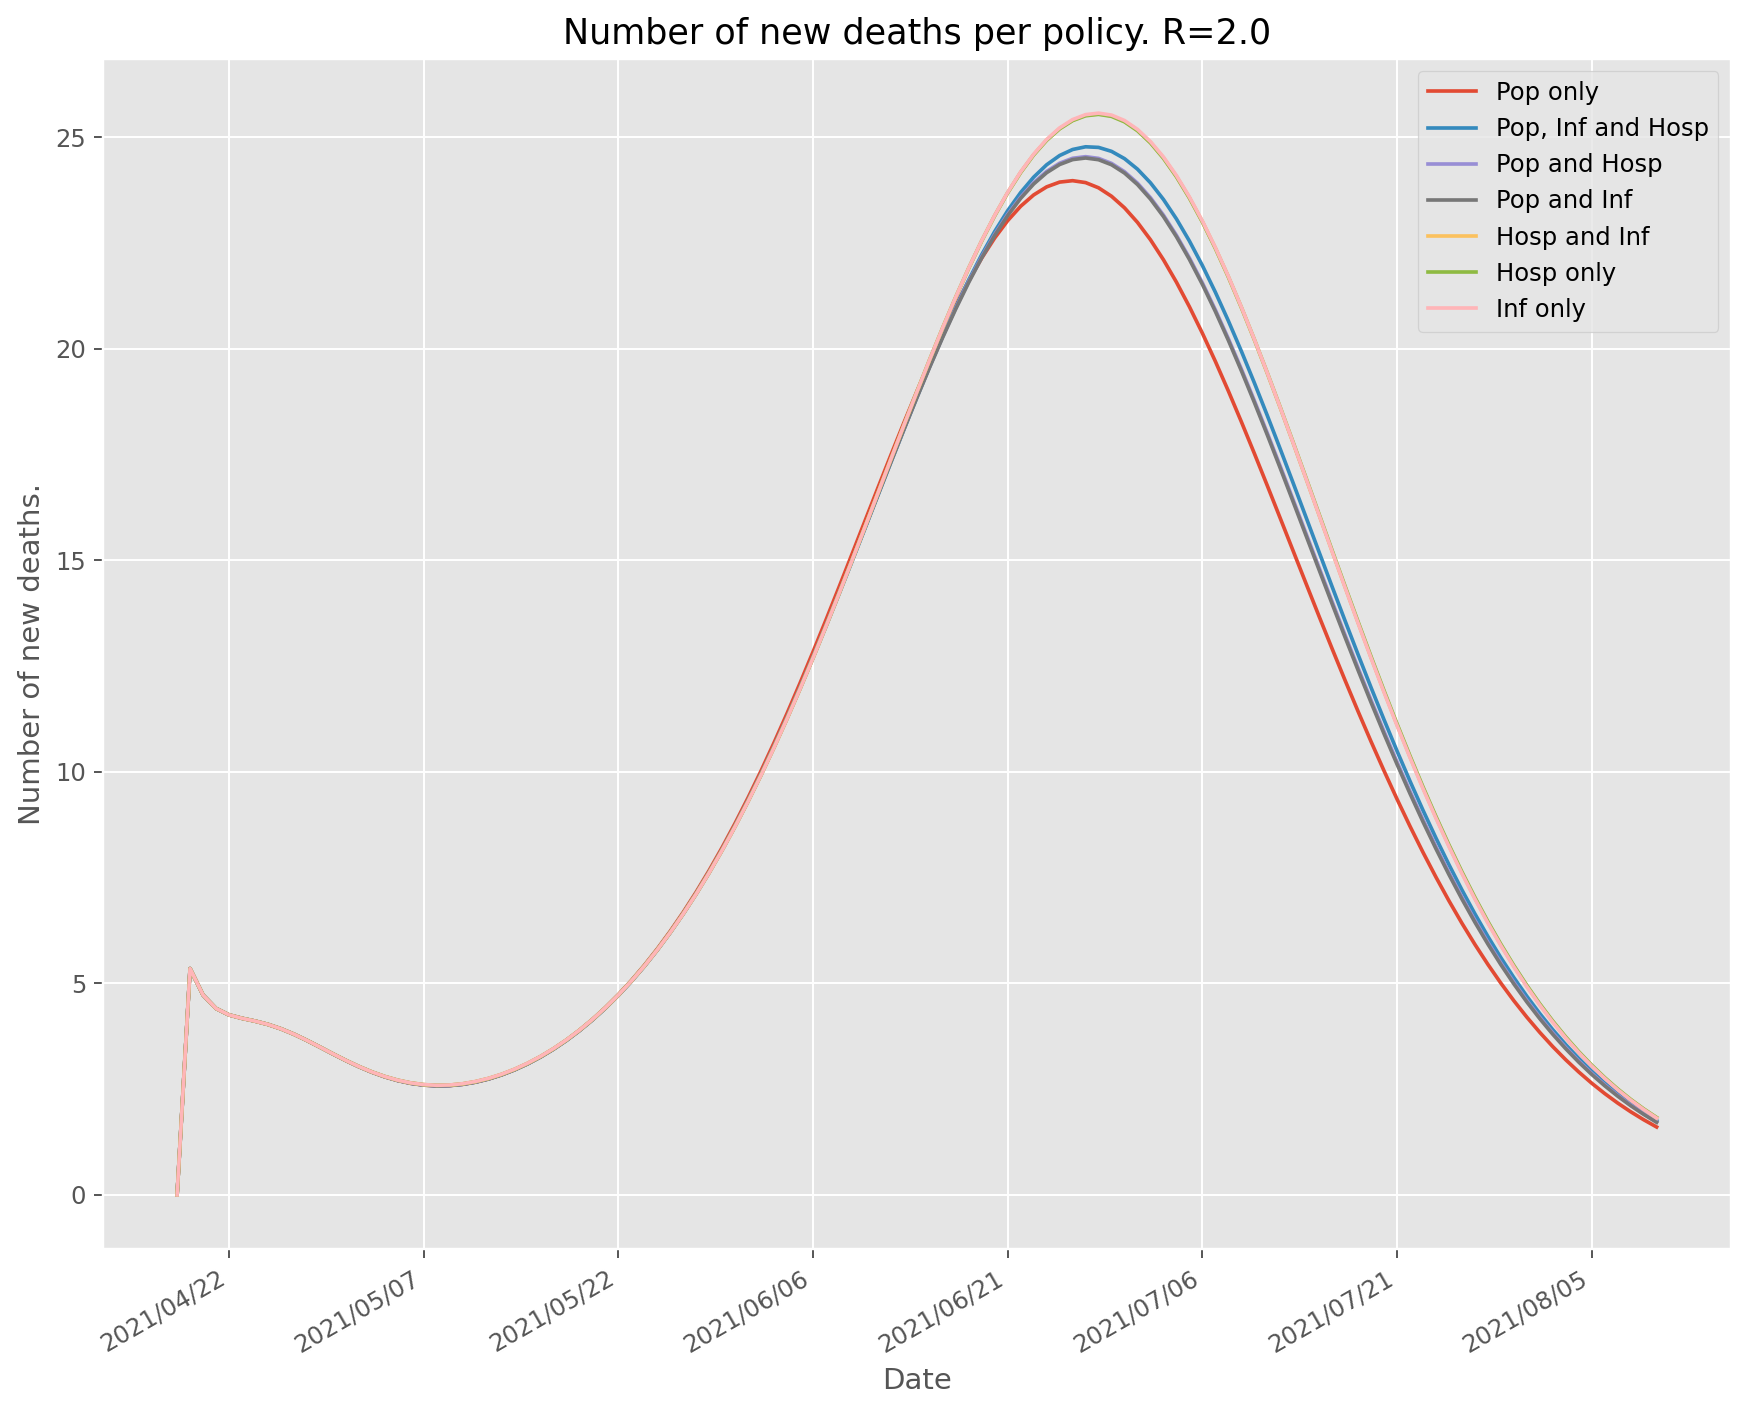

In [12]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[3], metric='new deaths', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

# Hospitalizations

Inf only: 8392.079049073162
Hosp and Inf: 8401.026586231537
Hosp only: 8411.624111687508
Pop, Inf and Hosp: 8432.933270723506
Pop and Inf: 8460.156372619927
Pop and Hosp: 8468.655580094623
Pop only: 8642.760430212878


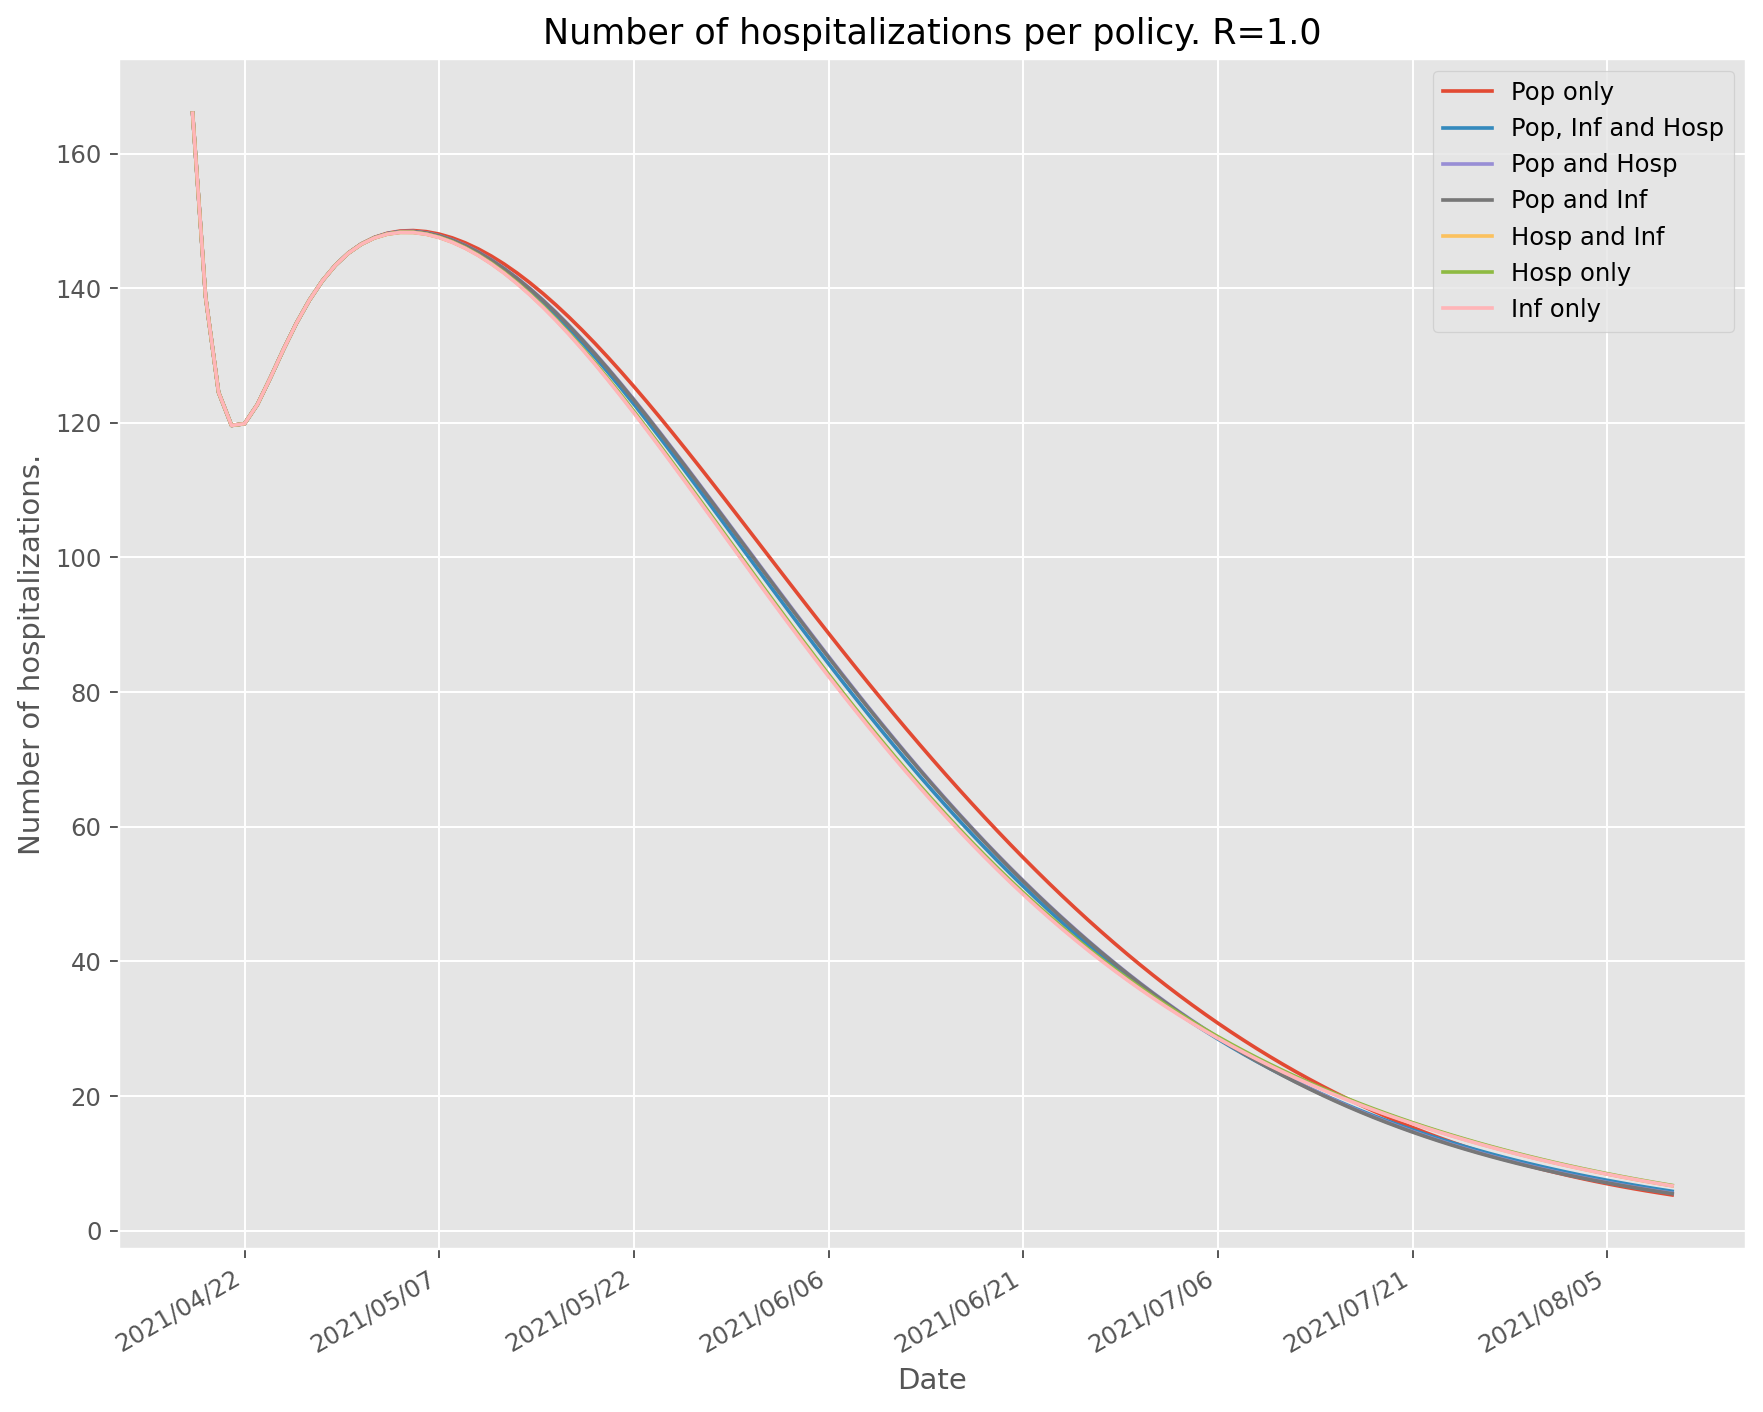

In [13]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[0], metric='hospitalizations', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

Pop and Inf: 24380.386450399797
Pop and Hosp: 24442.235550682304
Pop, Inf and Hosp: 24464.804660994494
Inf only: 24763.835089378863
Hosp and Inf: 24806.556527159235
Hosp only: 24868.84320703538
Pop only: 24976.28761559901


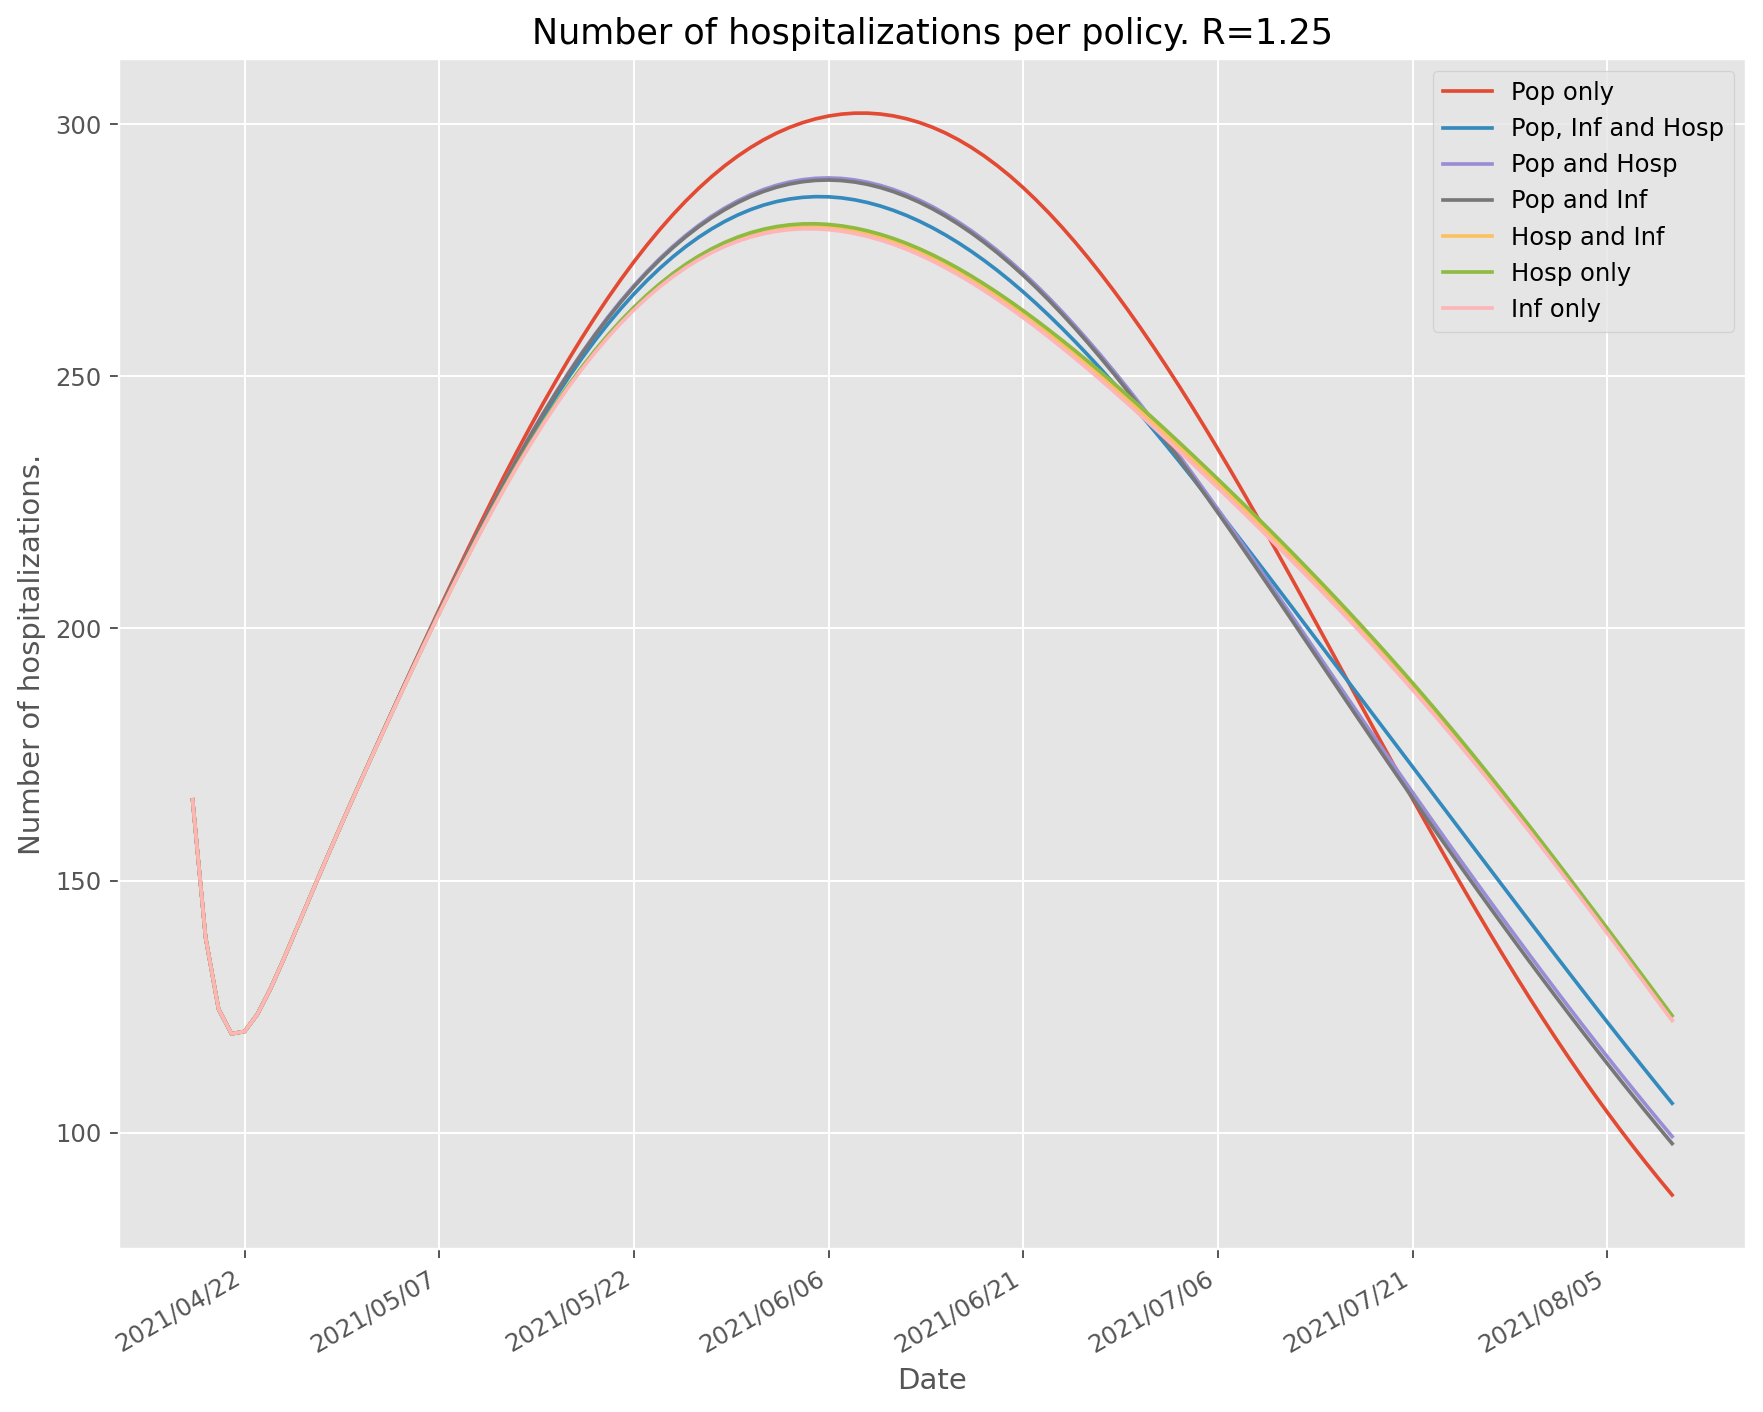

In [14]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[1], metric='hospitalizations', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

Pop only: 79845.05134737665
Pop and Inf: 80349.80456385373
Pop and Hosp: 80654.46812887794
Pop, Inf and Hosp: 81621.63078992433
Inf only: 84574.6005366468
Hosp and Inf: 84700.43956050815
Hosp only: 84939.70566883741


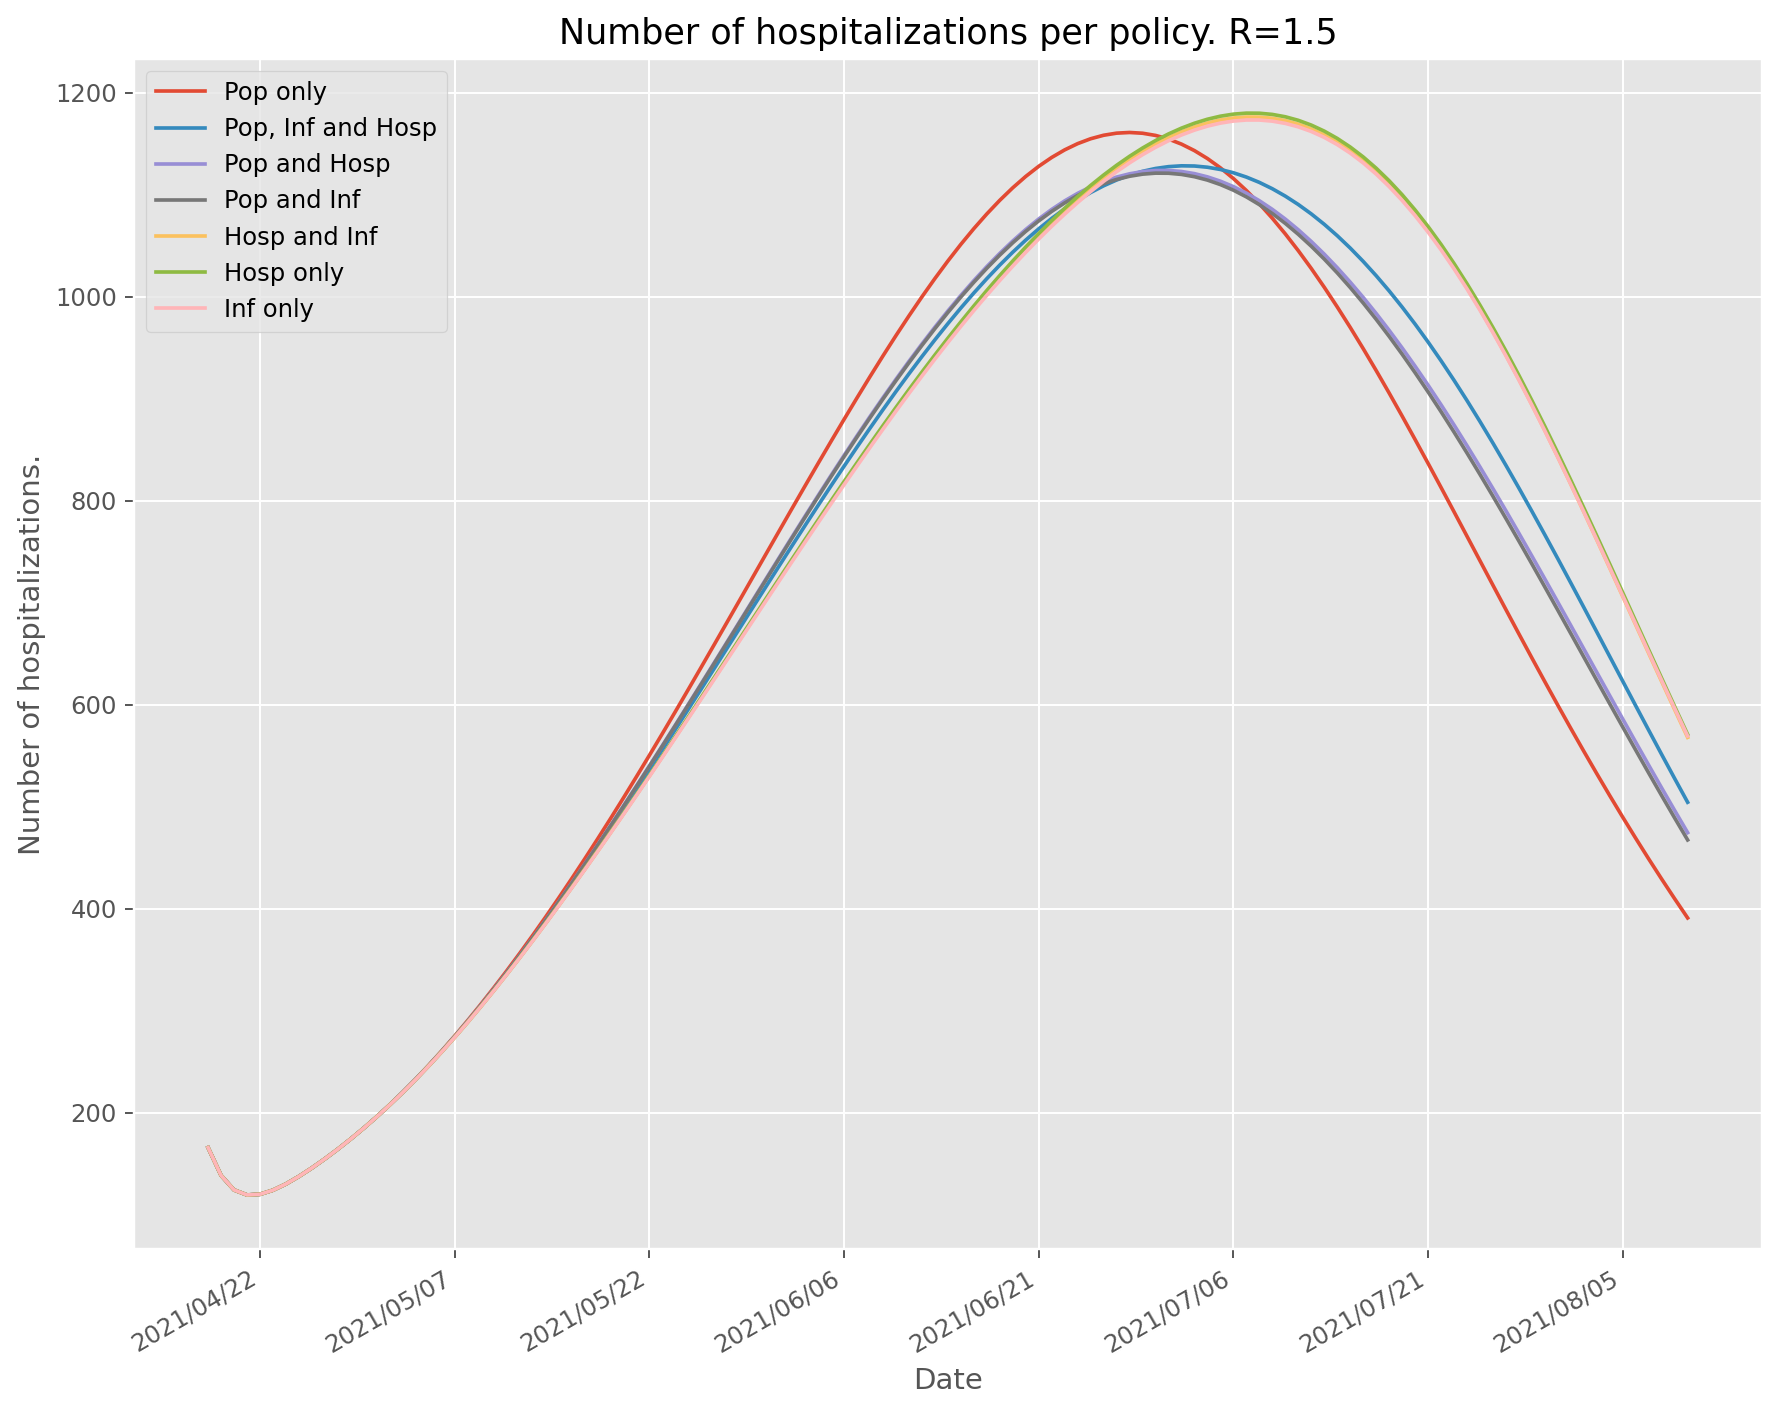

In [15]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[2], metric='hospitalizations', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

Pop only: 269527.8091932853
Pop and Inf: 275481.68768322794
Pop and Hosp: 276141.51524288545
Pop, Inf and Hosp: 279199.45211179013
Inf only: 287460.10803116
Hosp and Inf: 287873.4003189428
Hosp only: 288445.06643140945


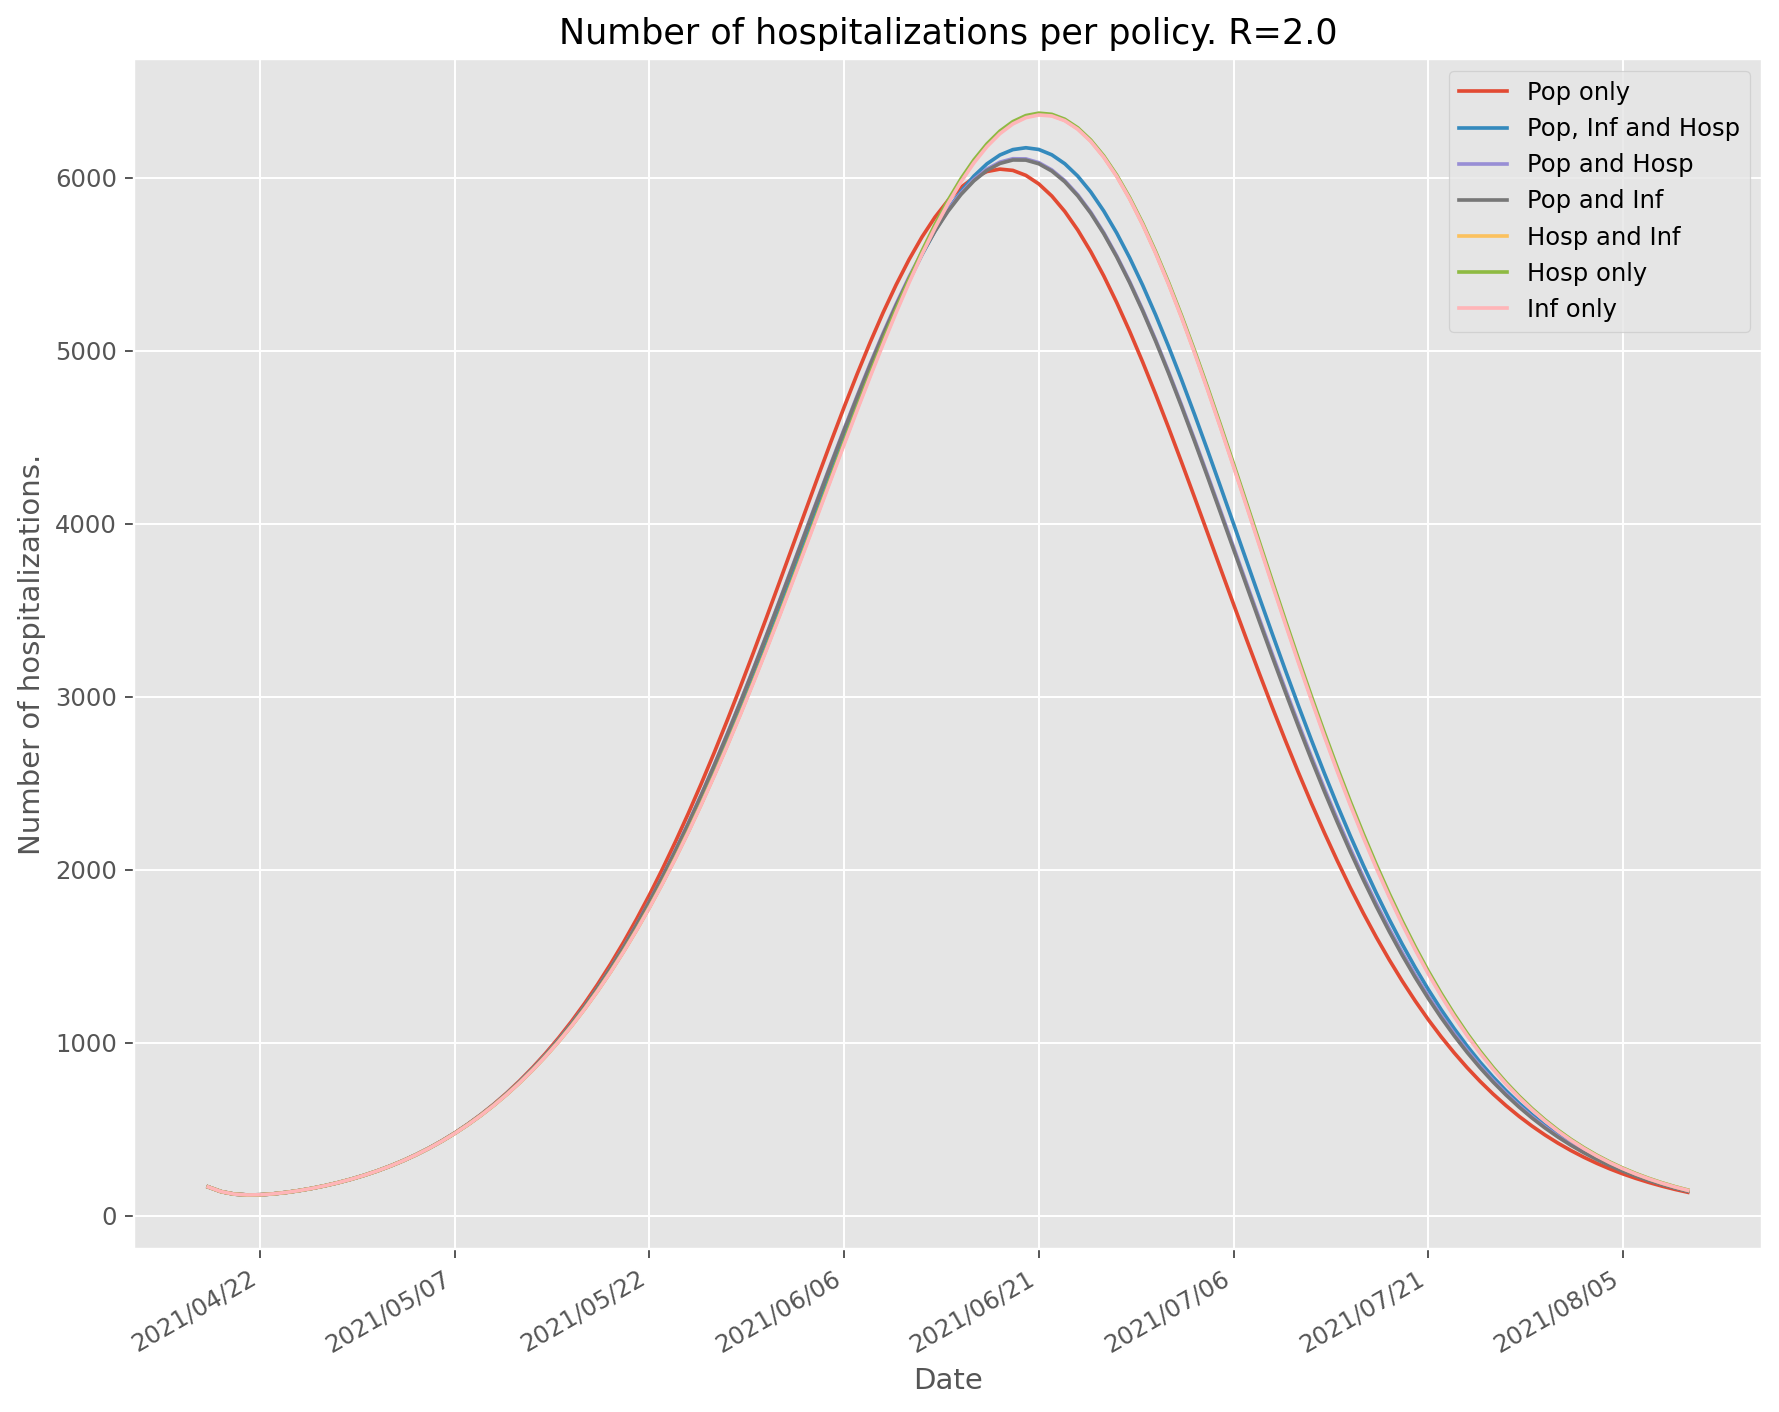

In [16]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[3], metric='hospitalizations', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

# Infections

Inf only: 211737.3224323458
Hosp and Inf: 211952.49846887332
Hosp only: 212158.65978094318
Pop, Inf and Hosp: 214393.84619149705
Pop and Inf: 215662.8955784799
Pop and Hosp: 215795.3653623023
Pop only: 220893.73720489113


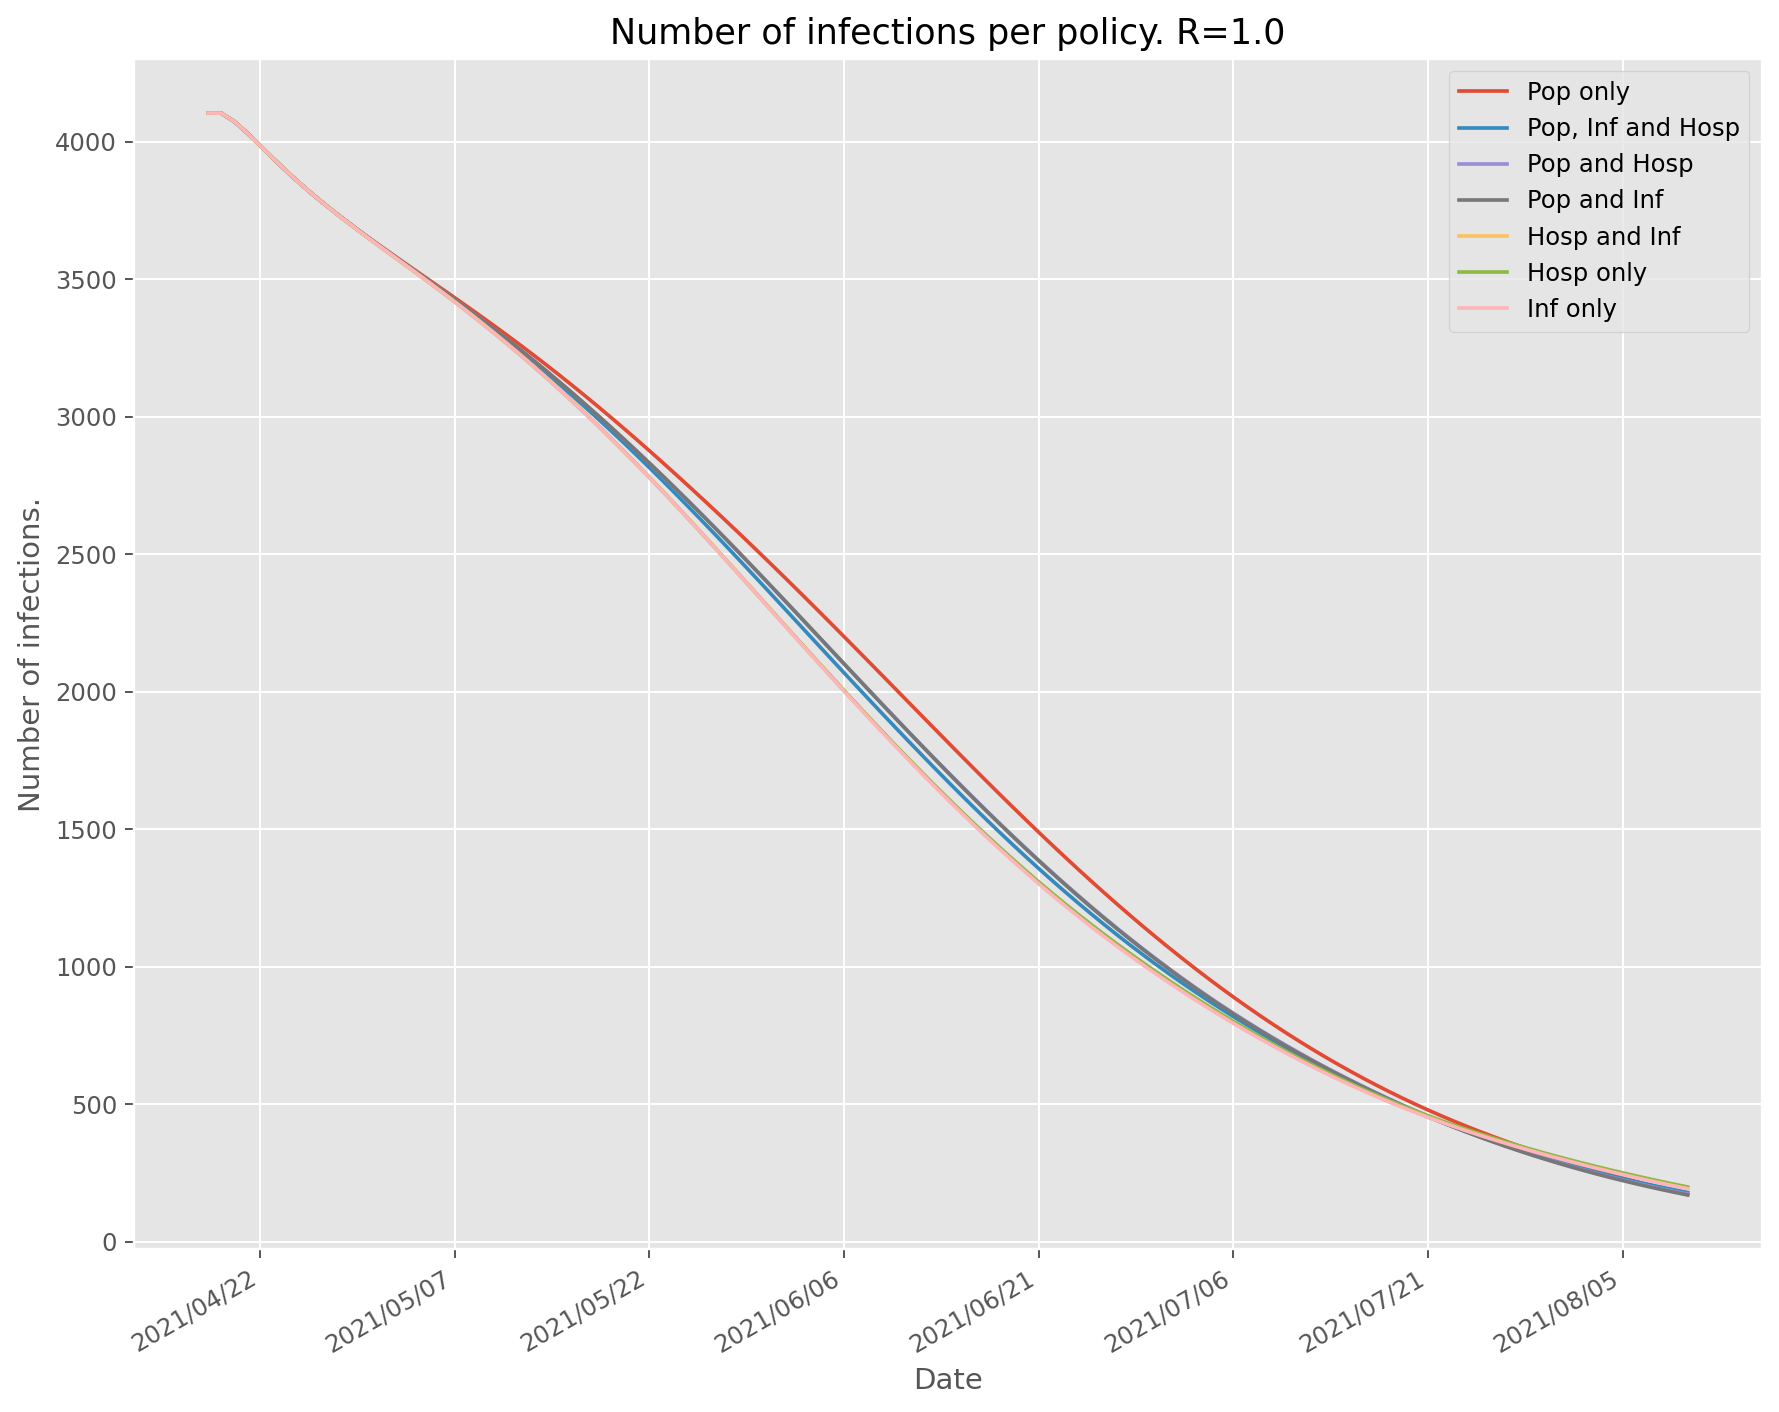

In [17]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[0], metric='infections', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

Inf only: 799907.0243823911
Hosp and Inf: 802122.6879388845
Hosp only: 804477.2678573648
Pop, Inf and Hosp: 805546.1799964067
Pop and Inf: 807127.9233322805
Pop and Hosp: 808925.2528873004
Pop only: 828958.6807984203


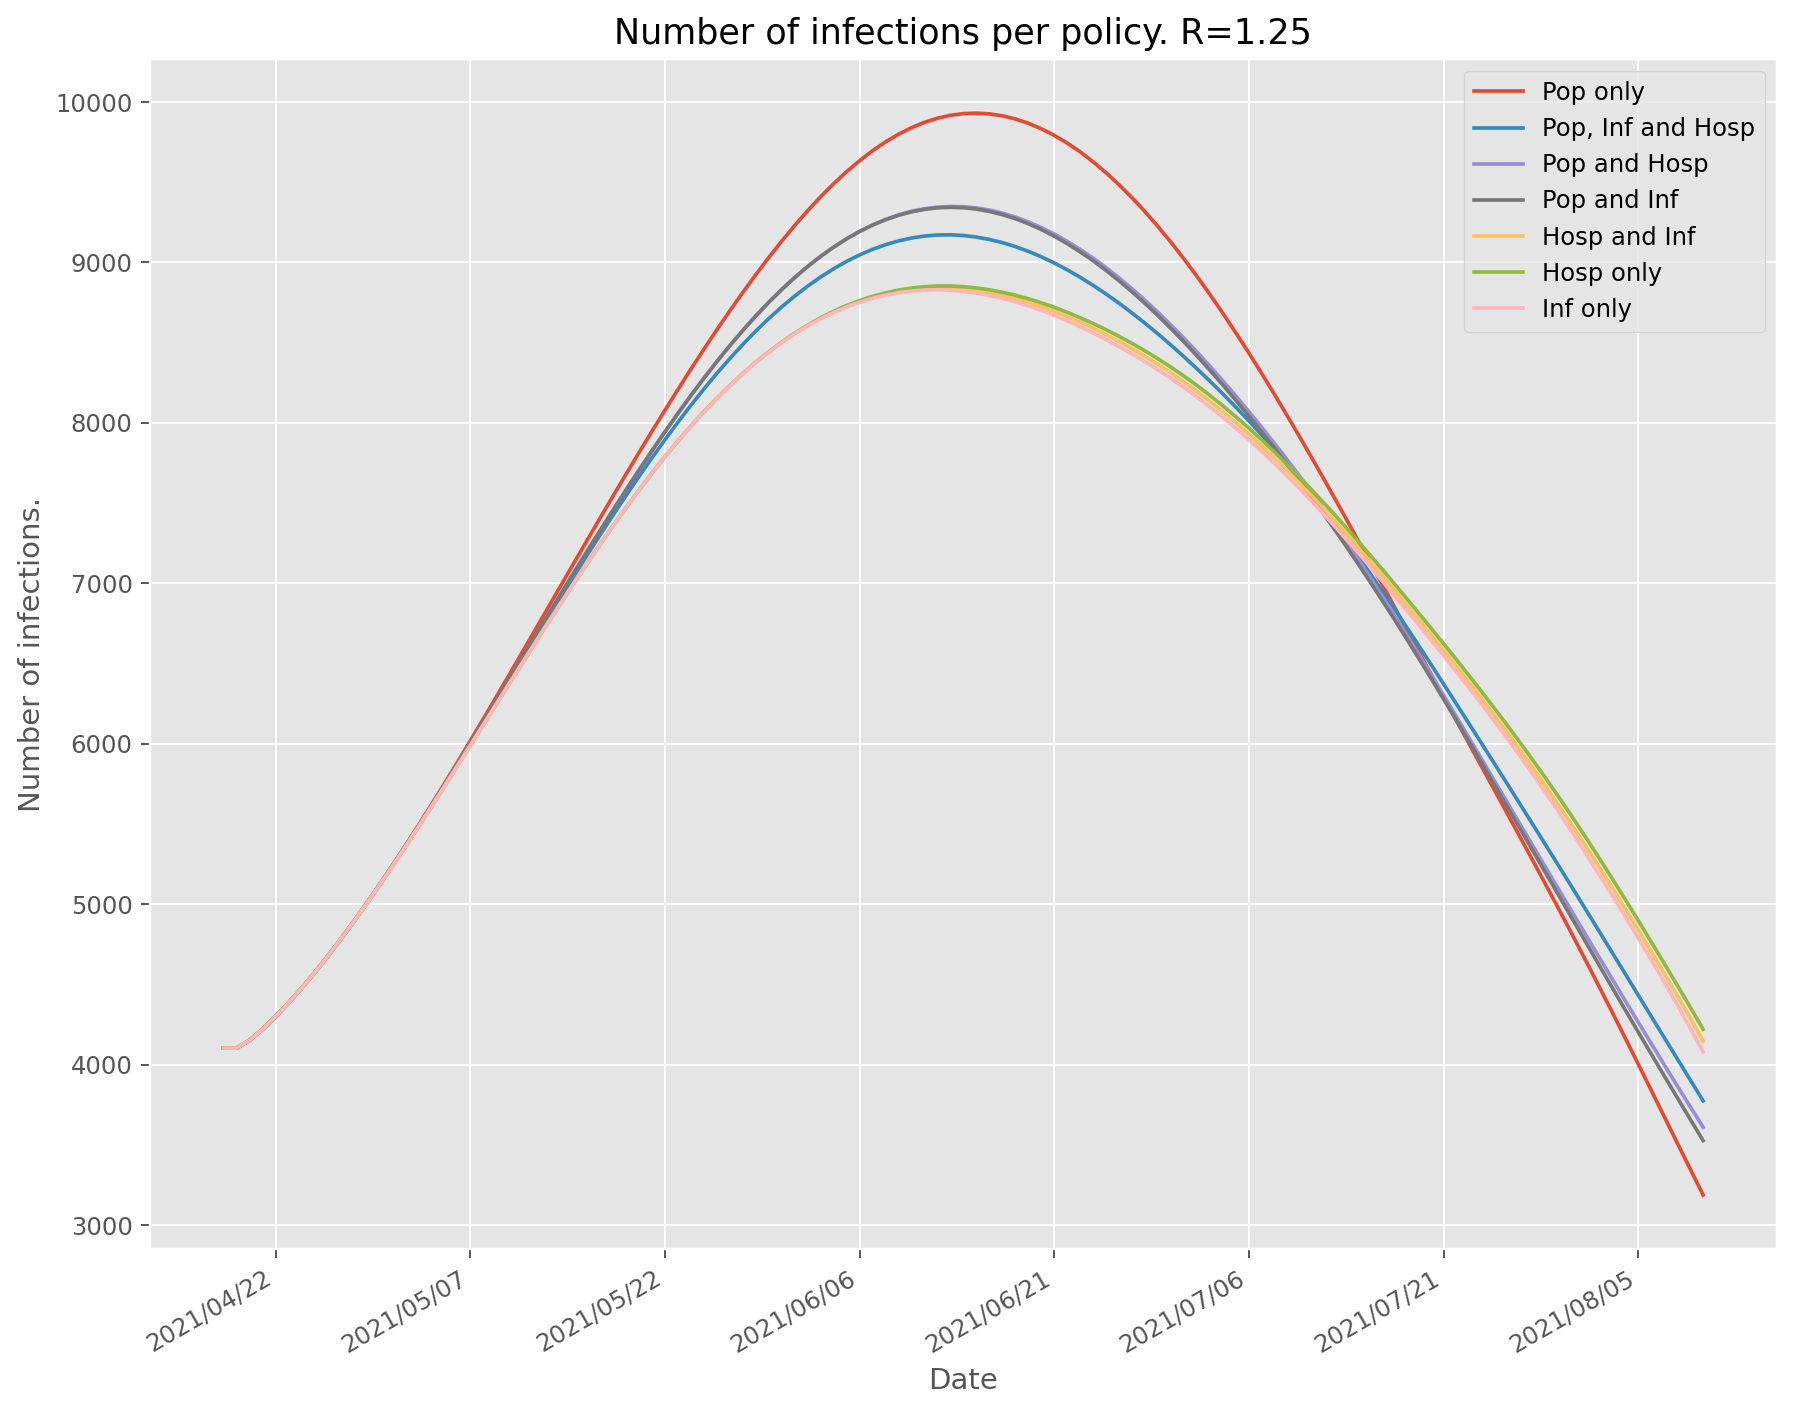

In [18]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[1], metric='infections', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

Pop and Inf: 2820706.3382559153
Pop only: 2821565.1232347484
Pop and Hosp: 2829328.611636247
Pop, Inf and Hosp: 2835315.8209599005
Inf only: 2843985.3876856263
Hosp and Inf: 2851375.3106162753
Hosp only: 2859805.15430302


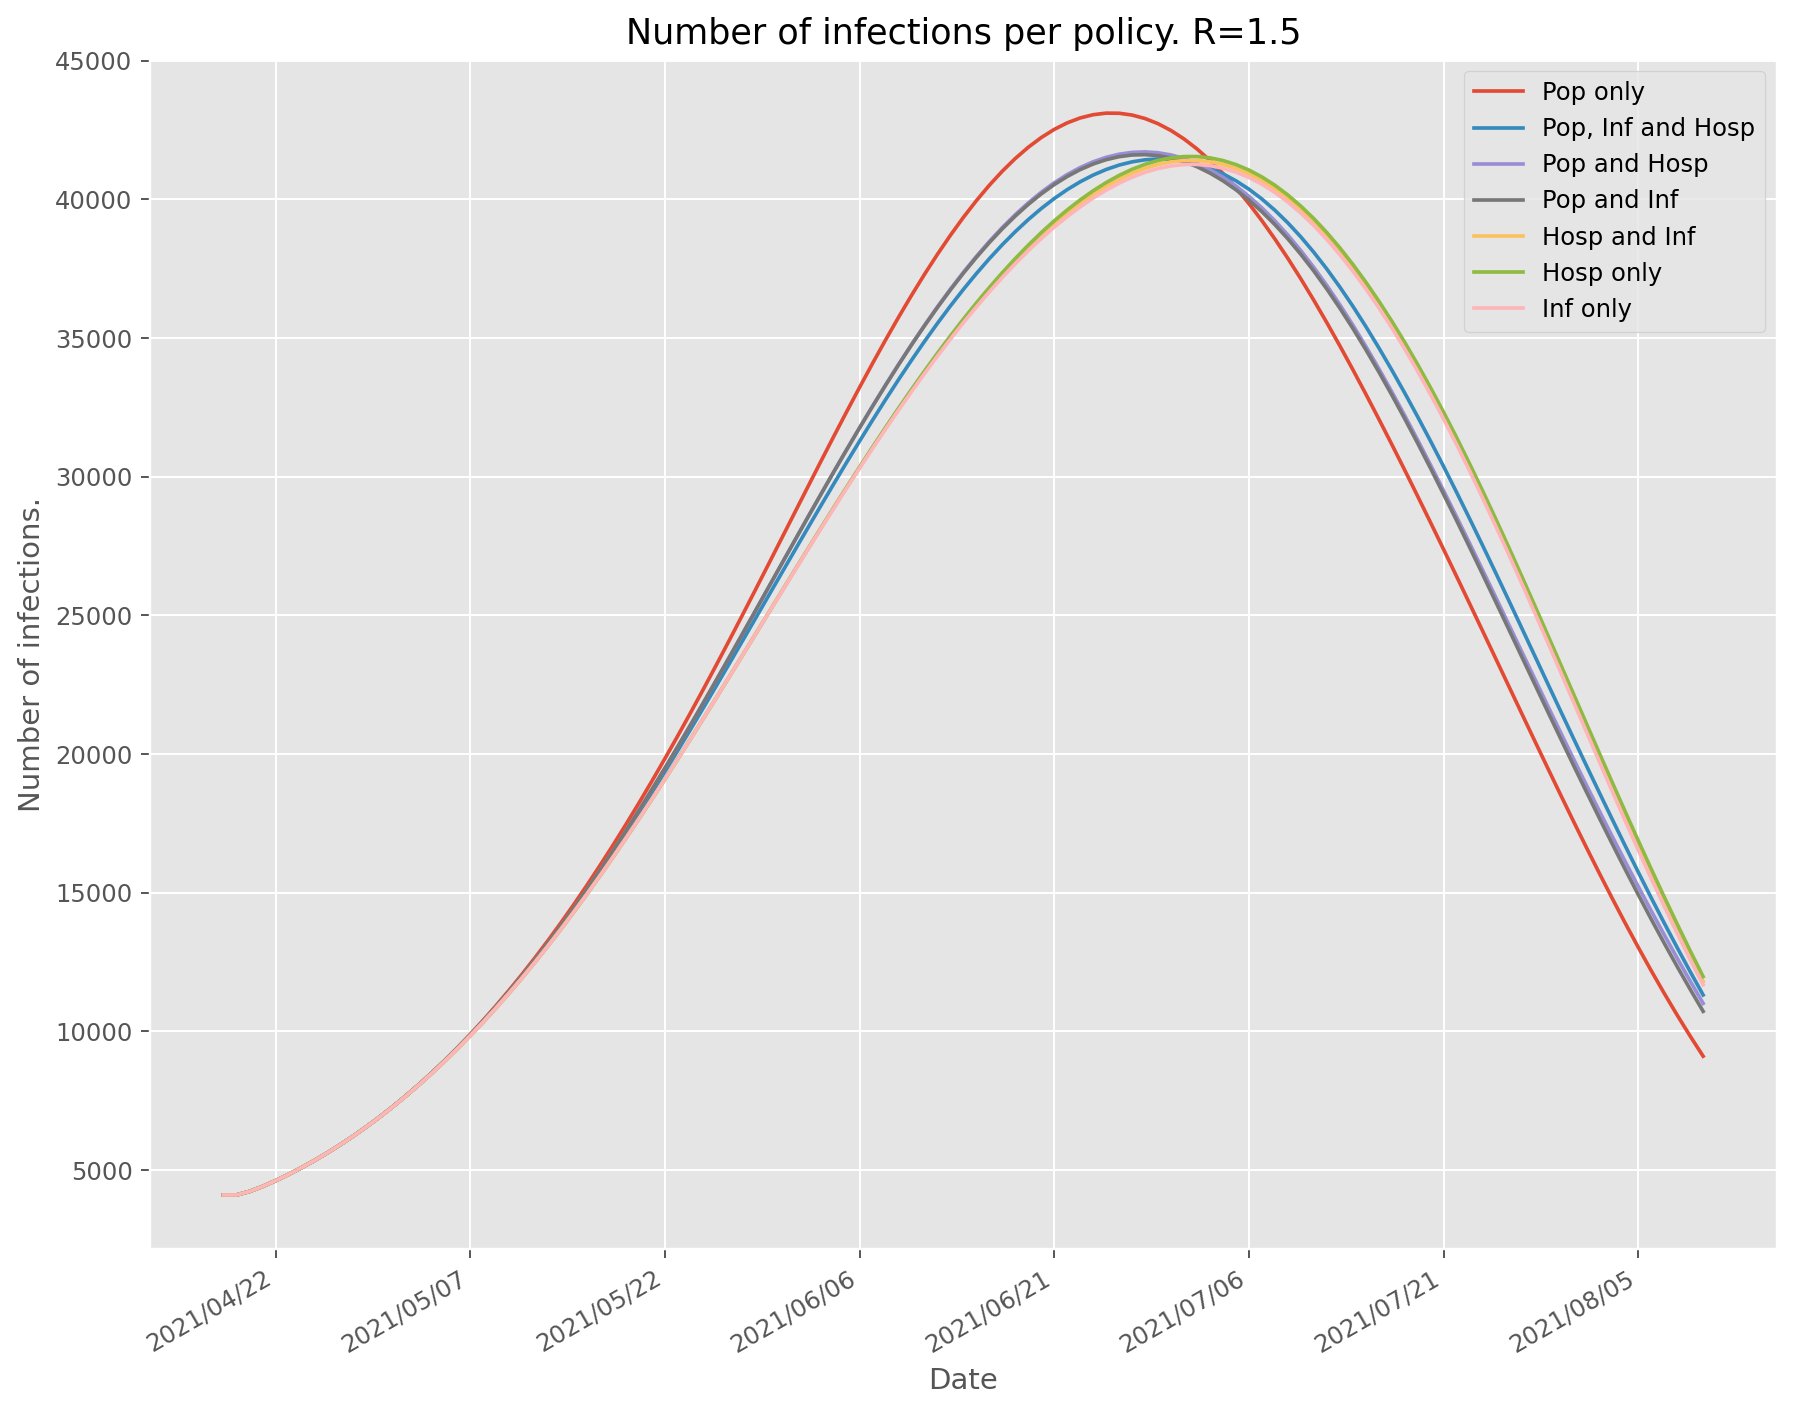

In [19]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[2], metric='infections', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

Pop only: 7708316.993869214
Pop and Inf: 7738828.488107912
Inf only: 7740786.038816665
Pop and Hosp: 7748664.851702872
Pop, Inf and Hosp: 7749953.029504585
Hosp and Inf: 7750074.812736842
Hosp only: 7758301.915025077


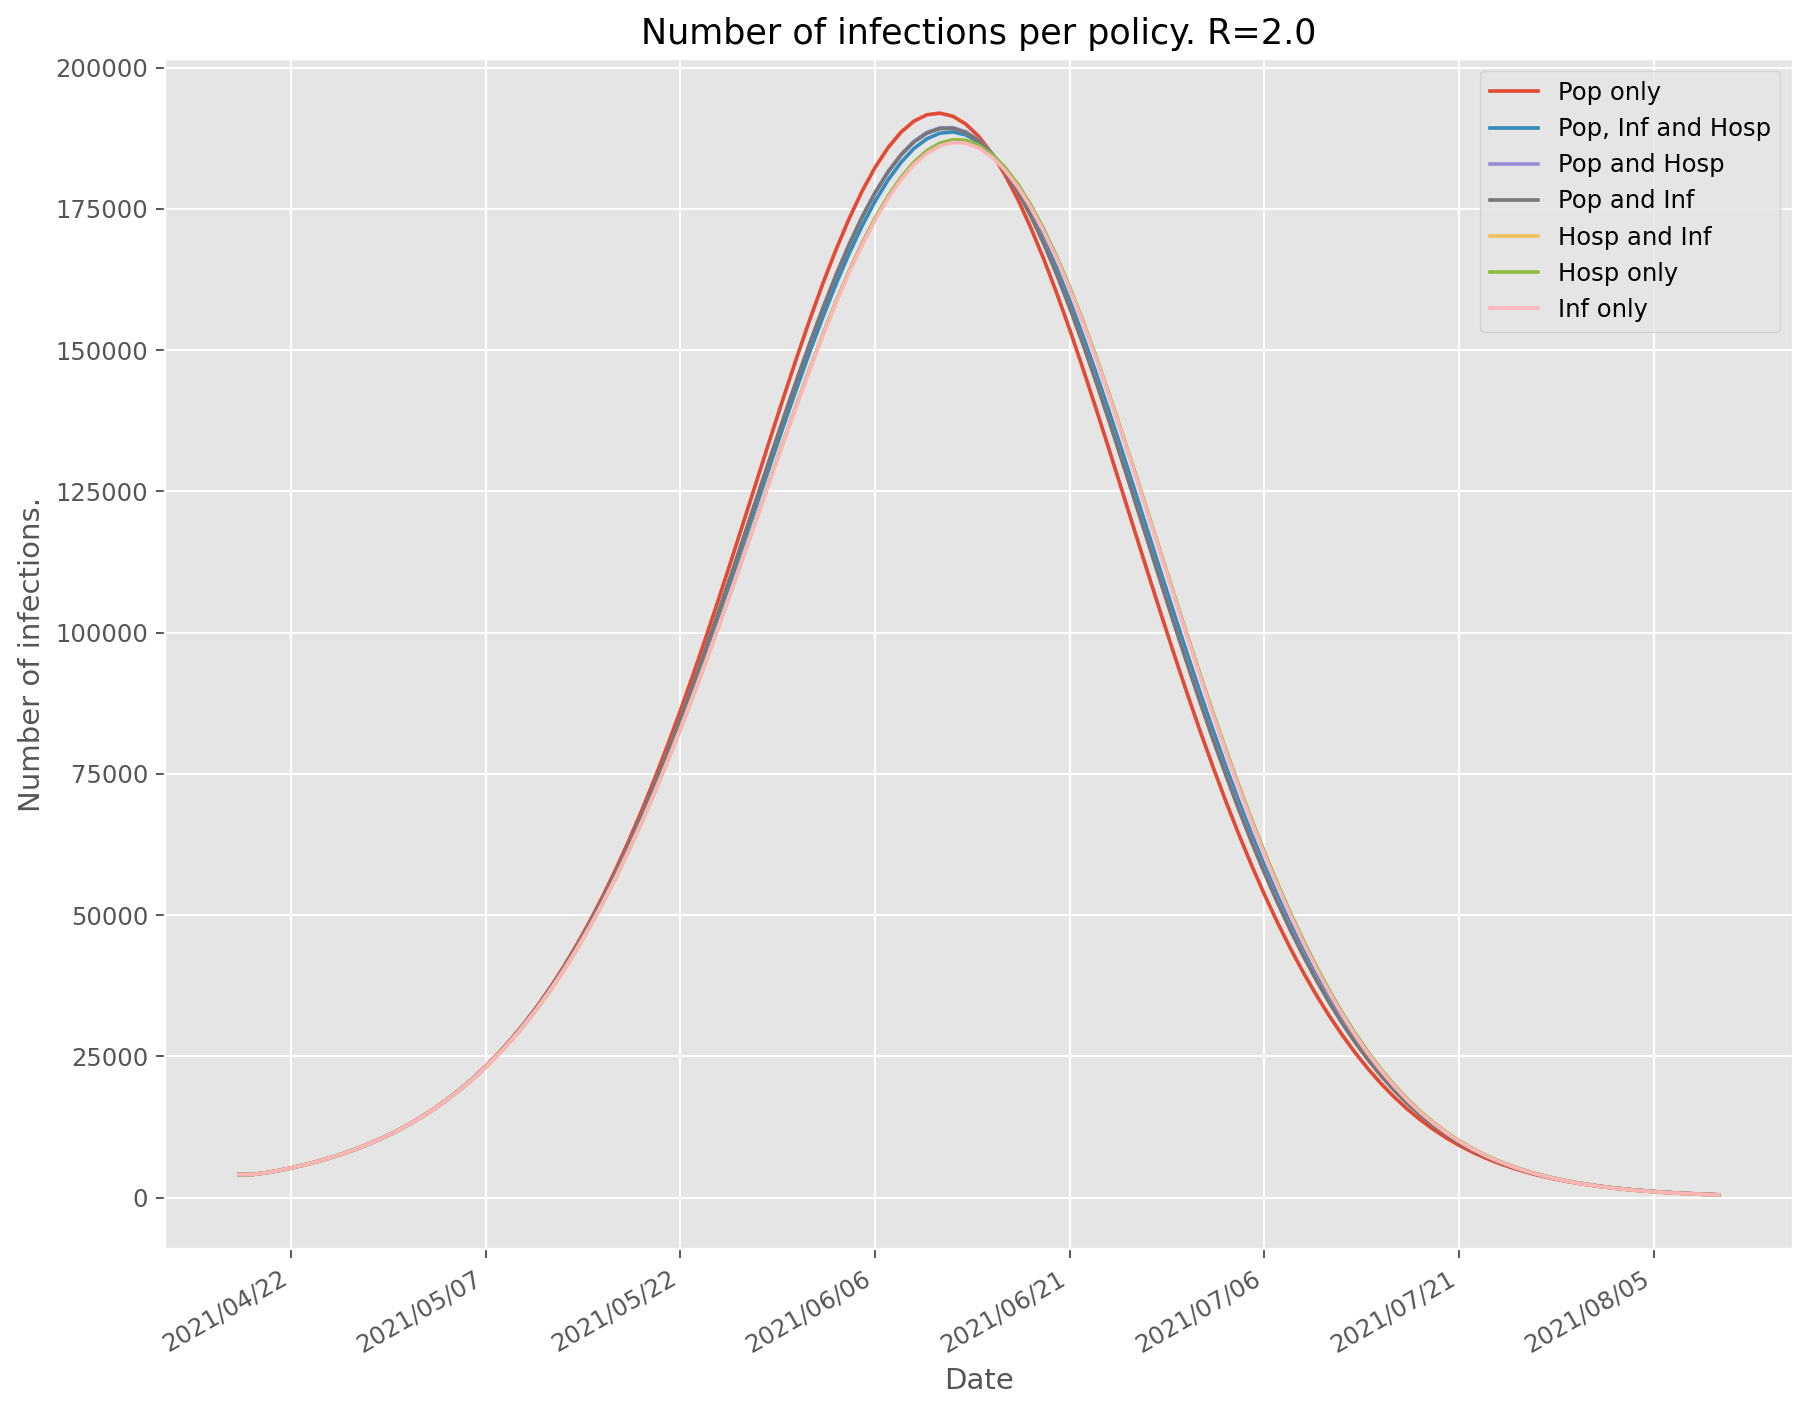

In [20]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[3], metric='infections', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()